In [1]:
import os
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
import boto3
from dotenv import load_dotenv
import warnings
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.metrics import (
    roc_curve,
    precision_recall_curve,
    auc,
    fbeta_score,
)
from sklearn.preprocessing import StandardScaler

from datetime import datetime
import re

random_state = 55

warnings.filterwarnings("ignore")

plt.style.use("seaborn-v0_8-darkgrid")
sns.set_palette("husl")
plt.rcParams["figure.figsize"] = (12, 8)
plt.rcParams["font.size"] = 12

load_dotenv()
AWS_ACCESS_KEY_ID = os.getenv("AWS_ACCESS_KEY_ID")
AWS_SECRET_ACCESS_KEY = os.getenv("AWS_SECRET_ACCESS_KEY")

## Get Dataset

In [2]:
FILE_NAME = "feature_frame.csv"
S3_DIR = "groceries/box_builder_dataset/"
BUCKET_NAME = "zrive-ds-data"
S3_PATH = "s3://" + BUCKET_NAME + S3_DIR + FILE_NAME
LOCAL_DATA_PATH = "../../data/"
LOCAL_FILE_PATH = LOCAL_DATA_PATH + FILE_NAME


def get_data_from_s3():
    """Download data from S3 if not exists locally."""
    os.makedirs(LOCAL_DATA_PATH, exist_ok=True)

    if os.path.exists(LOCAL_FILE_PATH):
        print(f"File already exists at {LOCAL_FILE_PATH}")
        return

    try:
        s3 = boto3.client(
            "s3",
            aws_access_key_id=AWS_ACCESS_KEY_ID,
            aws_secret_access_key=AWS_SECRET_ACCESS_KEY,
        )

        key = S3_DIR + FILE_NAME

        print(f"Downloading from {S3_PATH}")
        s3.download_file(BUCKET_NAME, key, LOCAL_FILE_PATH)
        print(f"File downloaded successfully to {LOCAL_FILE_PATH}")

    except Exception as e:
        print(f"Error downloading file: {e}")
        raise


# Download data if needed
get_data_from_s3()

# Load the dataset
df = pd.read_csv(LOCAL_FILE_PATH)

File already exists at ../../data/feature_frame.csv


## Filtering Data

We should only be focusing on purchases of at least 5 items, since it is a requirement coming from the sales team.

In [3]:
items_bought_per_order = (
    df[df["outcome"] == 1].groupby("order_id").size().reset_index(name="items_bought")
)
# row num diference between df and items_bought_per_order
df_with_count = df.merge(items_bought_per_order, on="order_id", how="left")
df_with_count["items_bought"].fillna(0, inplace=True)

sales_df = df_with_count[df_with_count["items_bought"] > 4]
print(
    f"Deleted items with less than 5 items bought: {len(df_with_count) - len(sales_df)}  ({(len(df_with_count) - len(sales_df))*100/len(df_with_count):.2f}%)"
)

Deleted items with less than 5 items bought: 716596  (24.88%)


## Data Split

I'll split the data in three subsets:
1. Train Data -> ~70%
2. Validation data -> ~20%
3. Test data -> ~10%

The key in most supervised learning is how we split the data. 
In this case: 
1. Mantain temporality, because the bussines may grow or evolve along the time, instead could be data leakage
2. I will not divide products in same order in different data splits, in order to avoid data leakage
3. I will make stratified sampling in order to preserve the target distribution

In [4]:
def temporal_split_data(
    df: pd.DataFrame,
    target_col: str = 'outcome',
    train_size: float = 0.7,
    val_size: float = 0.2,
    order_id_col: str = 'order_id',
    date_col: str = 'created_at'
) -> tuple:
    
    df_copy = df.copy()
    df_copy[date_col] = pd.to_datetime(df_copy[date_col])
    
    order_dates = df_copy.groupby(order_id_col)[date_col].min().reset_index()
    order_dates = order_dates.sort_values(date_col)
    
    total_orders = len(order_dates)
    train_orders = int(total_orders * train_size)
    val_orders = int(total_orders * val_size)
    
    train_orders_set = set(order_dates.iloc[:train_orders][order_id_col])
    val_orders_set = set(order_dates.iloc[train_orders:train_orders + val_orders][order_id_col])
    test_orders_set = set(order_dates.iloc[train_orders + val_orders:][order_id_col])
    
    train_mask = df_copy[order_id_col].isin(train_orders_set)
    val_mask = df_copy[order_id_col].isin(val_orders_set)
    test_mask = df_copy[order_id_col].isin(test_orders_set)
    
    X = df_copy.drop(columns=[target_col])
    y = df_copy[target_col]
    
    X_train = X[train_mask].copy()
    X_val = X[val_mask].copy()
    X_test = X[test_mask].copy()
    
    y_train = y[train_mask].copy()
    y_val = y[val_mask].copy()
    y_test = y[test_mask].copy()
    
    train_cutoff_date = order_dates.iloc[train_orders - 1][date_col]
    val_cutoff_date = order_dates.iloc[train_orders + val_orders - 1][date_col]
    
    print(f"  Train ({len(X_train)/len(df)*100:.2f}%): {len(X_train):,} rows ({len(train_orders_set):,} orders)")
    print(f"  Val   ({len(X_val)/len(df)*100:.2f}%): {len(X_val):,} rows ({len(val_orders_set):,} orders)")
    print(f"  Test  ({len(X_test)/len(df)*100:.2f}%): {len(X_test):,} rows ({len(test_orders_set):,} orders)")
    
    print(f"  Train cutoff: {train_cutoff_date}")
    print(f"  Val cutoff:   {val_cutoff_date}")
    
    print(f"  Train: {y_train.value_counts(normalize=True).to_dict()}")
    print(f"  Val:   {y_val.value_counts(normalize=True).to_dict()}")
    print(f"  Test:  {y_test.value_counts(normalize=True).to_dict()}")
    
    return X_train, X_val, X_test, y_train, y_val, y_test

X_train, X_val, X_test, y_train, y_val, y_test = temporal_split_data(
    df=df,
    target_col='outcome'
)

  Train (66.93%): 1,927,962 rows (2,412 orders)
  Val   (21.55%): 620,646 rows (689 orders)
  Test  (11.52%): 331,941 rows (345 orders)
  Train cutoff: 2021-02-08 13:41:15
  Val cutoff:   2021-02-24 09:53:18
  Train: {0.0: 0.9877139694662032, 1.0: 0.012286030533796828}
  Val:   {0.0: 0.9897526126004196, 1.0: 0.010247387399580437}
  Test:  {0.0: 0.9904049213565062, 1.0: 0.009595078643493874}


## Evaluate Model

I'll use Fbeta score (with beta 0.3) givin more importance to precision over recall

In [5]:
def fbeta_03_score(y_true, y_pred):
    return fbeta_score(y_true, y_pred, beta=0.3)

def evaluate_linear_model(model, X_test, y_test, model_name="Model"):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    
    f03_score = fbeta_03_score(y_test, y_pred)
    
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    
    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    pr_auc = auc(recall, precision)
    
    return {
        'name': model_name,
        'f03_score': f03_score,
        'y_proba': y_proba,
        'fpr': fpr,
        'tpr': tpr,
        'roc_auc': roc_auc,
        'precision': precision,
        'recall': recall,
        'pr_auc': pr_auc
    }

def plot_curves_comparison(results_list, title_suffix="", figsize=(15, 6)):
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    
    ax1.plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Random')
    
    for result in results_list:
        ax1.plot(result['fpr'], result['tpr'], 
                label=f"{result['name']} (F0.3={result['f03_score']:.3f})",
                linewidth=2)
    
    ax1.set_xlabel('False Positive Rate')
    ax1.set_ylabel('True Positive Rate')
    ax1.set_title(f'ROC Curves {title_suffix}')
    ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax1.grid(True, alpha=0.3)
    
    baseline_precision = results_list[0]['precision'].mean() if results_list else 0.5
    ax2.axhline(y=baseline_precision, color='k', linestyle='--', alpha=0.5, label='Baseline')
    
    for result in results_list:
        ax2.plot(result['recall'], result['precision'], 
                label=f"{result['name']} (F0.3={result['f03_score']:.3f})", 
                linewidth=2)
    
    ax2.set_xlabel('Recall')
    ax2.set_ylabel('Precision')
    ax2.set_title(f'Precision-Recall Curves {title_suffix}')
    ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    return fig

## Baseline

To compare and justify our ML Models, we should always beat a baseline.

In this case, the `global_popularity` feature will be a good baseline to decide if the user will purchase or not

In [6]:
class PopularityBaseline:
        def __init__(self, threshold, popularity_col):
            self.threshold = threshold
            self.popularity_col = popularity_col
        
        def predict(self, X):
            return (X[self.popularity_col] >= self.threshold).astype(int)
        
        def predict_proba(self, X):
            proba_pos = X[self.popularity_col] / X[self.popularity_col].max()
            proba_neg = 1 - proba_pos
            return np.column_stack([proba_neg, proba_pos])
    
PopularityBaseline = PopularityBaseline(0.05, 'global_popularity')

## Building linear model

We have the dataset ready for sales team, now, we have to develop a machine learning model that, given a user and a product, predicts if the user would purchase. 

In [9]:
sales_df.columns

Index(['variant_id', 'product_type', 'order_id', 'user_id', 'created_at',
       'order_date', 'user_order_seq', 'outcome', 'ordered_before',
       'abandoned_before', 'active_snoozed', 'set_as_regular',
       'normalised_price', 'discount_pct', 'vendor', 'global_popularity',
       'count_adults', 'count_children', 'count_babies', 'count_pets',
       'people_ex_baby', 'days_since_purchase_variant_id',
       'avg_days_to_buy_variant_id', 'std_days_to_buy_variant_id',
       'days_since_purchase_product_type', 'avg_days_to_buy_product_type',
       'std_days_to_buy_product_type', 'items_bought'],
      dtype='object')

So, we have to build a model to predict the 'outcome' feature given the other features:

- User info ->    ```user_order_seq```, ```count_adults```, ```count_children```, ```count_babies```, ```count_pets```, ```people_ex_baby```
- Product info -> ```product_type```, ```normalised_price```, ```discount_pct```, ```vendor```, ```global_popularity```
- Product-User info -> ```ordered_before```, ```abandoned_before```, ```active_snoozed```, ```set_as_regular``` and those related with days since...
- Target -> ```outcome```

What happens with other variables? 

- IDs -> Don`t give numeric information, delete it (```order_id``` will be important to split data, but then, delete it)
- Items_bought -> We won´t have that info in production


We still have 2 variables left: 
1. ```created_at```: In production will be the current date. I will preprocess it and get day num, month num and week num.
2. ```order_date```: Redundant, delete it. 


In [10]:
target = "outcome"
cols_to_drop = ["variant_id", "user_id", "order_date", "items_bought"]
order_id_col = "order_id"

feature_cols = sales_df.columns[~sales_df.columns.isin(cols_to_drop + [target])]
feature_cols

Index(['product_type', 'order_id', 'created_at', 'user_order_seq',
       'ordered_before', 'abandoned_before', 'active_snoozed',
       'set_as_regular', 'normalised_price', 'discount_pct', 'vendor',
       'global_popularity', 'count_adults', 'count_children', 'count_babies',
       'count_pets', 'people_ex_baby', 'days_since_purchase_variant_id',
       'avg_days_to_buy_variant_id', 'std_days_to_buy_variant_id',
       'days_since_purchase_product_type', 'avg_days_to_buy_product_type',
       'std_days_to_buy_product_type'],
      dtype='object')

Now, we are going to try with differents models, iteratively, so first models only will have binary and numeric columns

In [11]:
numeric_cols = sales_df[feature_cols].select_dtypes(include=[np.number]).columns.tolist()
numeric_cols.remove('order_id')
categorical_cols = sales_df[feature_cols].select_dtypes(exclude=[np.number]).columns.tolist()

In [12]:
def create_numeric_logistic_pipelines():
    
    pipelines = {}
    
    pipelines['No Penalty'] = Pipeline([
        ('scaler', StandardScaler()),
        ('model', LogisticRegression(penalty=None, max_iter=1000, random_state=random_state))
    ])
    
    C_values = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1]
    
    for C in C_values:
        pipelines[f'L1 (C={C})'] = Pipeline([
            ('scaler', StandardScaler()),
            ('model', LogisticRegression(penalty='l1', C=C, solver='liblinear', 
                                       max_iter=1000, random_state=random_state))
        ])
    
    for C in C_values:
        pipelines[f'L2 (C={C})'] = Pipeline([
            ('scaler', StandardScaler()),
            ('model', LogisticRegression(penalty='l2', C=C, max_iter=1000, 
                                       random_state=random_state))
        ])
    
    return pipelines

We are goint to compare how regularization performs in this dataset, comparing ridge and lasso

   Training No Penalty...
   Training L1 (C=1e-06)...
   Training L1 (C=1e-05)...
   Training L1 (C=0.0001)...
   Training L1 (C=0.001)...
   Training L1 (C=0.01)...
   Training L1 (C=0.1)...
   Training L2 (C=1e-06)...
   Training L2 (C=1e-05)...
   Training L2 (C=0.0001)...
   Training L2 (C=0.001)...
   Training L2 (C=0.01)...
   Training L2 (C=0.1)...
   ✅ All models trained


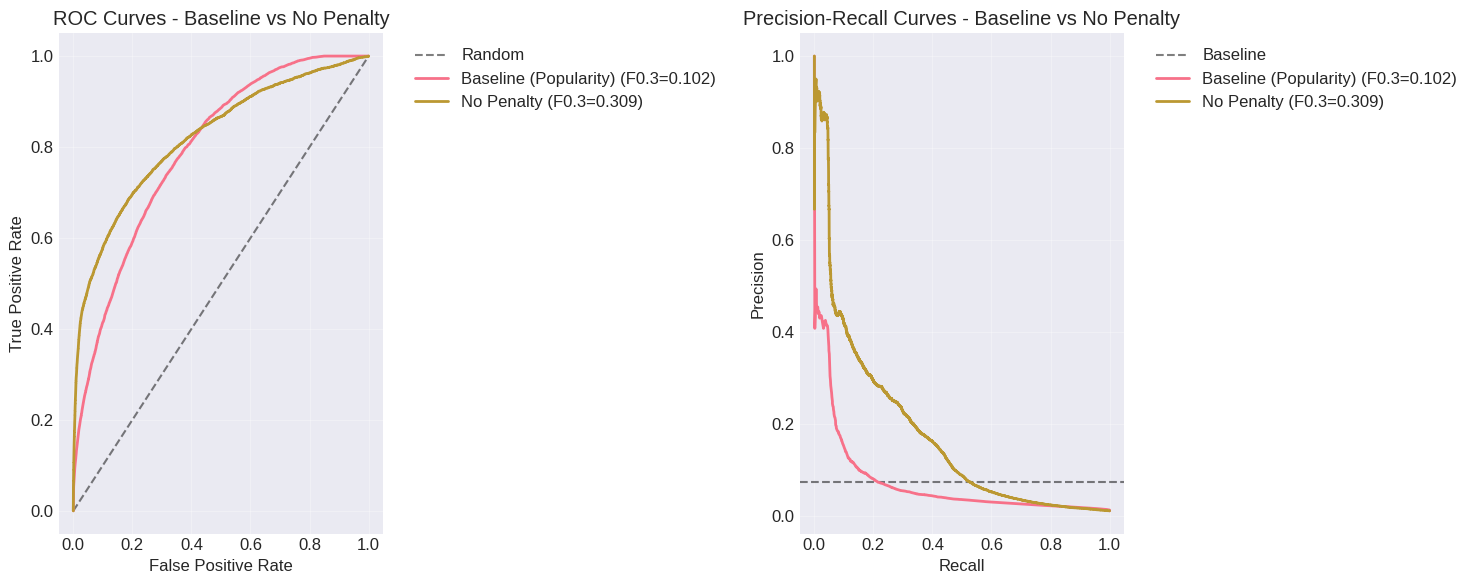

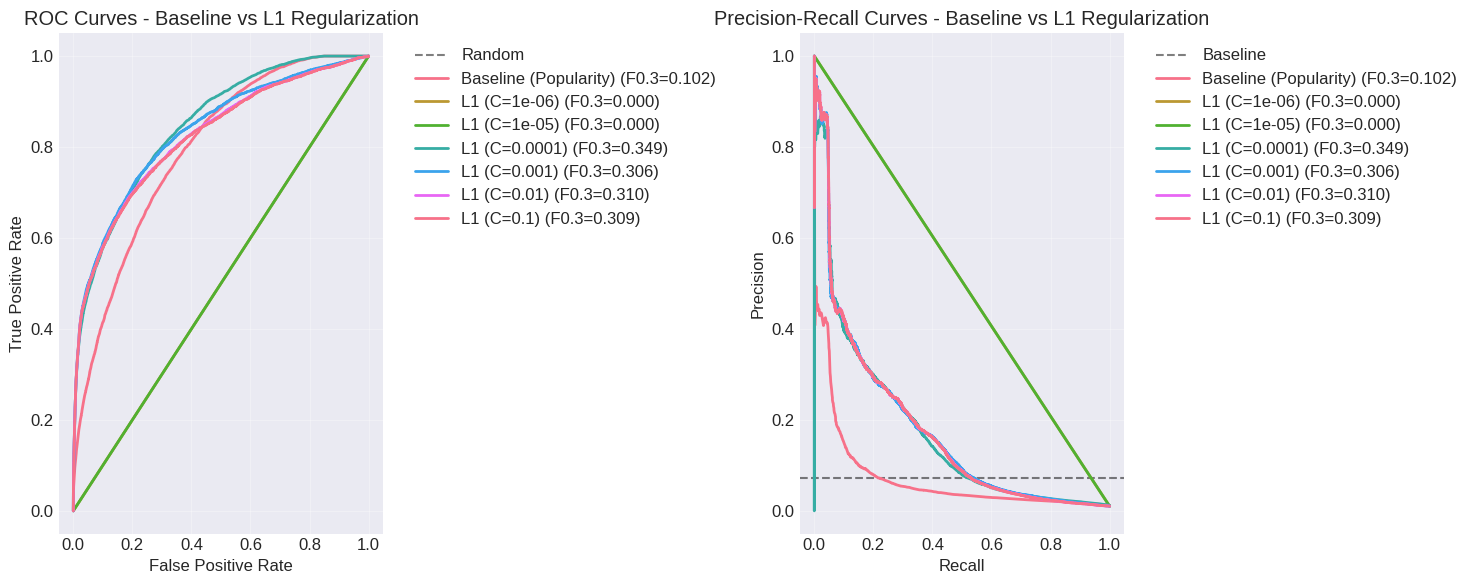

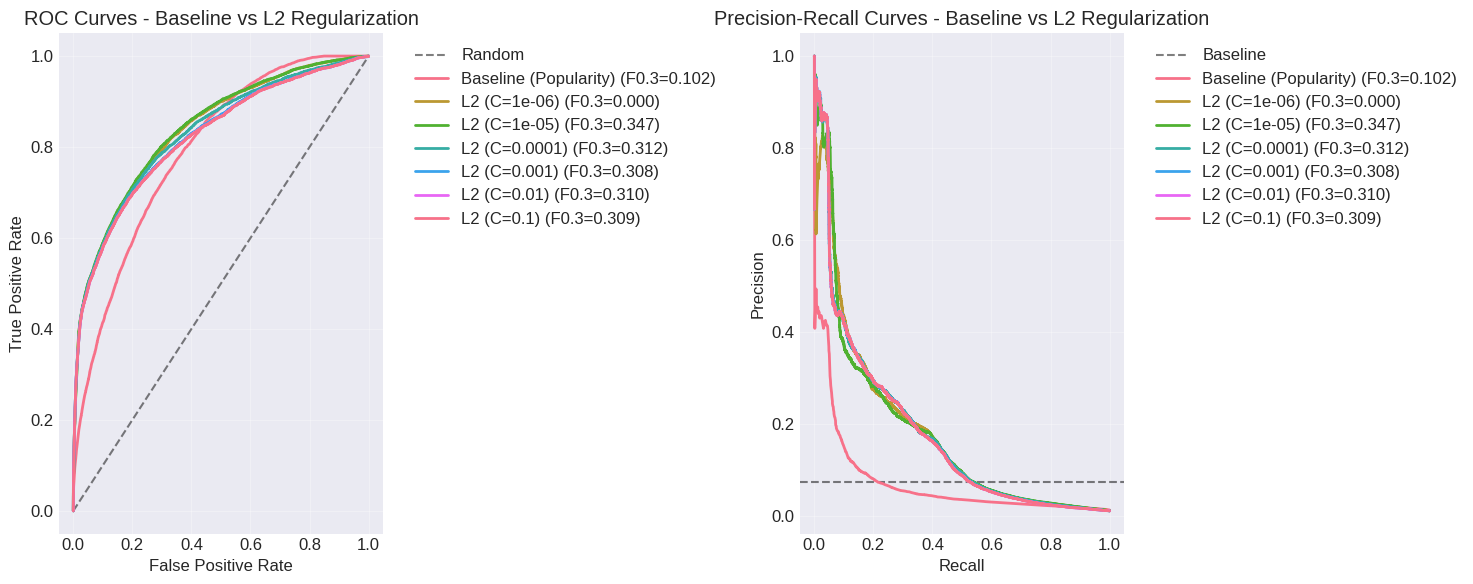

In [13]:

X_train_num = X_train[numeric_cols].copy()
X_val_num = X_val[numeric_cols].copy() 
X_test_num = X_test[numeric_cols].copy()

pipelines = create_numeric_logistic_pipelines()

trained_models = {}
for name, pipeline in pipelines.items():
    print(f"   Training {name}...")
    pipeline.fit(X_train_num, y_train)
    trained_models[name] = pipeline

print("   ✅ All models trained")

all_results = []
baseline_result = evaluate_linear_model(PopularityBaseline, X_val_num, y_val, "Baseline (Popularity)")
all_results.append(baseline_result)

for name, model in trained_models.items():
    result = evaluate_linear_model(model, X_val_num, y_val, name)
    all_results.append(result)

baseline_results = [r for r in all_results if 'Baseline' in r['name'] or 'No Penalty' in r['name']]
l1_results = [r for r in all_results if 'Baseline' in r['name'] or 'L1' in r['name']]
l2_results = [r for r in all_results if 'Baseline' in r['name'] or 'L2' in r['name']]

fig1 = plot_curves_comparison(baseline_results, "- Baseline vs No Penalty")
plt.show()

fig2 = plot_curves_comparison(l1_results, "- Baseline vs L1 Regularization")
plt.show()

fig3 = plot_curves_comparison(l2_results, "- Baseline vs L2 Regularization")
plt.show()

The baseline is beated by far. Regularization improves the performance but there isn't so much diference. These are slighly best models:
1. `L1 (C=0.0001)`
2. `L2 (C=1e-05)`

Let's see how regularization is affecting the parameters

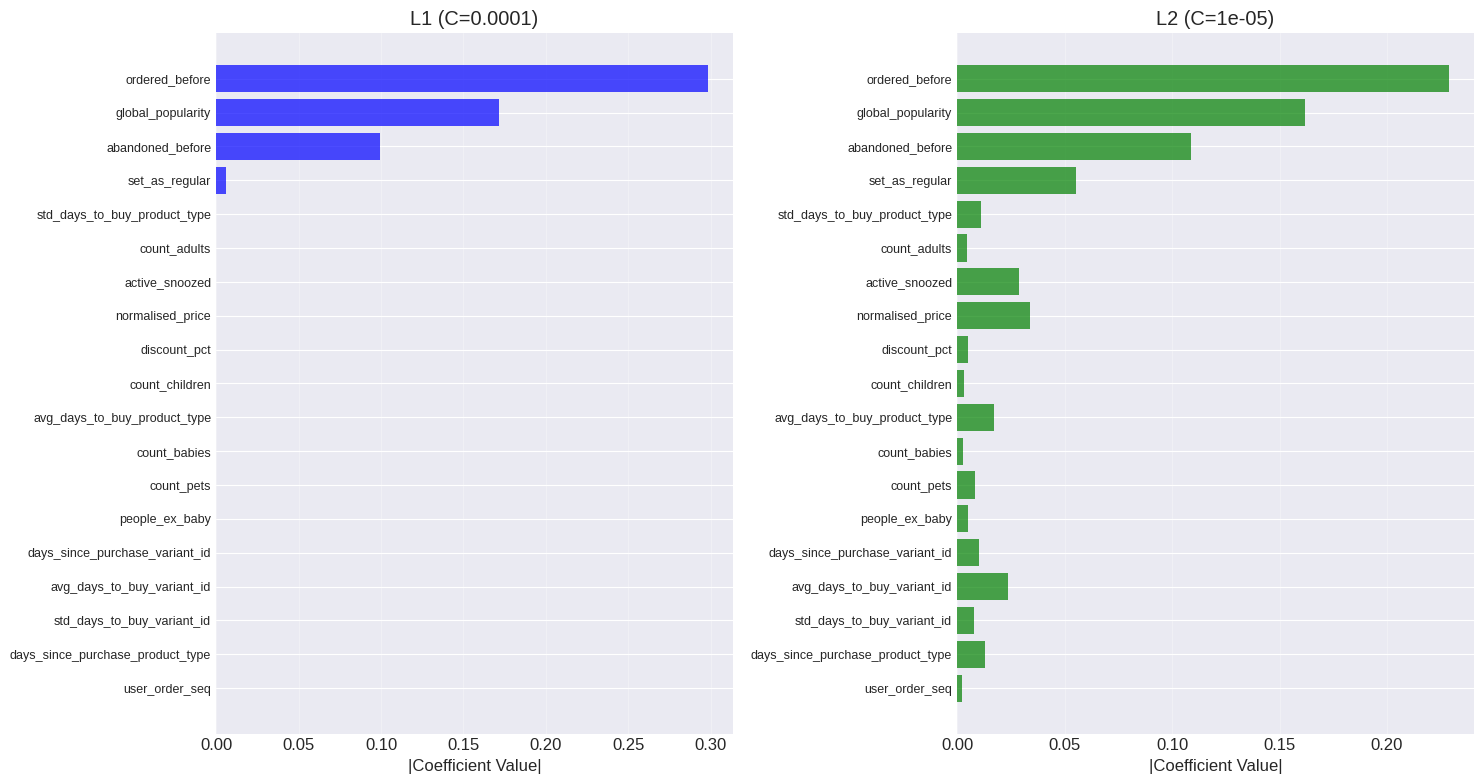

In [14]:
def plot_model_weights(
    l1_model_name: str, l2_model_name: str, numeric_cols, figsize=(15, 8)
):
    
    l1_model = trained_models[l1_model_name]
    l2_model = trained_models[l2_model_name]
    
    l1_coefs = l1_model.named_steps['model'].coef_[0]
    l2_coefs = l2_model.named_steps['model'].coef_[0]
    
    weights_df = pd.DataFrame({
        'Feature': numeric_cols,
        'L1_Weight': np.abs(l1_coefs),  
        'L2_Weight': np.abs(l2_coefs)
    })
    
    weights_df = weights_df.sort_values('L1_Weight', ascending=True) 
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    
    ax1.barh(range(len(weights_df)), weights_df['L1_Weight'], color='blue', alpha=0.7)
    ax1.set_yticks(range(len(weights_df)))
    ax1.set_yticklabels(weights_df['Feature'], fontsize=9)
    ax1.set_xlabel('|Coefficient Value|')
    ax1.set_title(f'{l1_model_name}')
    ax1.grid(True, alpha=0.3, axis='x')
    
    ax2.barh(range(len(weights_df)), weights_df['L2_Weight'], color='green', alpha=0.7)
    ax2.set_yticks(range(len(weights_df)))
    ax2.set_yticklabels(weights_df['Feature'], fontsize=9)
    ax2.set_xlabel('|Coefficient Value|')
    ax2.set_title(f'{l2_model_name}')
    ax2.grid(True, alpha=0.3, axis='x')
    
    plt.tight_layout()
    plt.show()

plot_model_weights('L1 (C=0.0001)', 'L2 (C=1e-05)', numeric_cols)

We can se that features `ordered_before`, `global_popularity`, `abandoned_before` and `set_as_regular` are the most importants. So we are going to remove the other ones

In [15]:
predictive_cols = [
    'ordered_before',
    'global_popularity',
    'abandoned_before',
    'set_as_regular'
]

### Add `created_at` feature

Now, i'll try adding the categorical `created_at` feature, but first i'll preproces it:

```created_at``` feature has this type: **'2020-02-05 16:46:19'**

That isn´t a numeric value, so I will create 6 features from that date:
1. ```year``` (2020)
2. ```month_num``` (02)
3. ```dom``` day of the month (05)
4. ```doy``` day of the year (36)
5. ```woy``` week of the year (05)
5. ```is_weekend``` 0 or 1

In [6]:
class DateFeatureTransformer(BaseEstimator, TransformerMixin):

    def __init__(self, date_column="created_at"):
        self.date_column = date_column
        self.date_feature_names = [
            'year', 'month_num', 'dom', 'doy', 'woy', 'dow_num', 'is_weekend'
        ]

    def process_date(self, input_str: str) -> dict:
        date_str = input_str.split(" ")[0]

        regex = re.compile(r"\d{4}-\d{2}-\d{2}")
        if not re.match(regex, date_str):
            return {name: 0 for name in self.date_feature_names}

        my_date = datetime.strptime(date_str, "%Y-%m-%d").date()
        date_feats = {}

        date_feats["year"] = int(my_date.strftime("%Y"))
        date_feats["month_num"] = int(my_date.strftime("%m"))
        date_feats["dom"] = int(my_date.strftime("%d"))
        date_feats["doy"] = int(my_date.strftime("%j"))
        date_feats["woy"] = int(my_date.strftime("%W"))

        # Fixing day of week to start on Mon (1), end on Sun (7)
        dow = my_date.strftime("%w")
        if dow == "0":
            dow = 7
        date_feats["dow_num"] = int(dow)

        date_feats["is_weekend"] = 1 if int(dow) > 5 else 0

        return date_feats

    def fit(self, X, y=None):
        self.feature_names_in_ = X.columns.tolist()
        return self

    def transform(self, X):
        X_copy = X.copy()

        date_features = []
        for date_value in X_copy[self.date_column]:
            date_features.append(self.process_date(str(date_value)))

        date_df = pd.DataFrame(date_features, index=X_copy.index)

        X_transformed = pd.concat([X_copy, date_df], axis=1)
        X_transformed = X_transformed.drop(columns=[self.date_column])

        return X_transformed
    
    def get_feature_names_out(self, input_features=None):
        if input_features is None:
            input_features = self.feature_names_in_
        
        output_features = [f for f in input_features if f != self.date_column]
        output_features.extend(self.date_feature_names)
        
        return np.array(output_features)

### Categorical Encoders

Also, I'll try with Frecuency encoders and Target Encoder on `vendor` and `product_type` features

In [6]:
class FrequencyEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, categorical_columns):
        self.categorical_columns = categorical_columns
        self.frequency_maps = {}

    def fit(self, X, y=None):
        self.feature_names_in_ = X.columns.tolist()
        for column in self.categorical_columns:
            if column in X.columns:
                frequencies = X[column].value_counts(normalize=True).to_dict()
                self.frequency_maps[column] = frequencies
        return self

    def transform(self, X):
        X_copy = X.copy()

        for column in self.categorical_columns:
            if column in X_copy.columns:
                default_value = (
                    min(self.frequency_maps[column].values())
                    if self.frequency_maps[column]
                    else 0
                )
                X_copy[column] = X_copy[column].map(
                    lambda x: self.frequency_maps[column].get(x, default_value)
                )

        return X_copy
    
    def get_feature_names_out(self, input_features=None):
        if input_features is None:
            input_features = self.feature_names_in_
        
        return np.array(input_features)


class TargetEncoder(BaseEstimator, TransformerMixin):
    def __init__(
        self,
        categorical_columns,
        target_column="outcome",
        min_samples_leaf=1,
        smoothing=1.0,
    ):
        self.categorical_columns = categorical_columns
        self.target_column = target_column
        self.min_samples_leaf = min_samples_leaf
        self.smoothing = smoothing
        self.target_means = {}
        self.global_mean = 0

    def fit(self, X, y=None):
        self.feature_names_in_ = X.columns.tolist()

        self.global_mean = y.mean()

        if len(X) != len(y):
            raise ValueError("X and y must have the same number of rows")

        for column in self.categorical_columns:
            if column in X.columns:
                temp_df = pd.DataFrame({
                    'category': X[column],
                    'target': y
                })
                agg_df = temp_df.groupby('category').agg({
                    'target': ['count', 'mean']
                })
                agg_df.columns = ['count', 'mean']
                agg_df['smooth_mean'] = (
                    (agg_df['count'] * agg_df['mean'] + self.smoothing * self.global_mean) /
                    (agg_df['count'] + self.smoothing)
                )

                self.target_means[column] = agg_df['smooth_mean'].to_dict()

        return self

    def transform(self, X):
        X_copy = X.copy()
        
        for column in self.categorical_columns:
            if column in X_copy.columns:
                X_copy[column] = X_copy[column].map(
                    lambda x: self.target_means[column].get(x, self.global_mean)
                )
        
        return X_copy
    
    def get_feature_names_out(self, input_features=None):
        if input_features is None:
            input_features = self.feature_names_in_
        
        return np.array(input_features)

In [16]:
def create_categorical_pipeline(encoder_type='frequency', penalty='l1', C=0.0001):
    
    if encoder_type == 'frequency':
        categorical_transformer = FrequencyEncoder(categorical_cols)
    elif encoder_type == 'target':
        categorical_transformer = TargetEncoder(categorical_cols)
    else:
        raise ValueError("encoder_type must be 'frequency' or 'target'")
    
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), predictive_cols), 
            ('cat', categorical_transformer, categorical_cols), 
            ('date', DateFeatureTransformer(), ['created_at']) 
        ],
        remainder='drop' 
    )
    
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('model', LogisticRegression(
            penalty=penalty, C=C, solver='liblinear', 
            max_iter=1000, random_state=random_state
        ))
    ])
    
    return pipeline

categorical_pipelines = {
    'Frequency Encoder': create_categorical_pipeline('frequency', 'l1', 0.0001),
    'Target Encoder': create_categorical_pipeline('target', 'l1', 0.0001)
}

X_train_cat = X_train[predictive_cols + categorical_cols].copy()
X_val_cat = X_val[predictive_cols + categorical_cols].copy()
X_test_cat = X_test[predictive_cols + categorical_cols].copy()

trained_categorical_models = {}
for name, pipeline in categorical_pipelines.items():
    print(f"   Training {name}...")
    pipeline.fit(X_train_cat, y_train)
    trained_categorical_models[name] = pipeline


   Training Frequency Encoder...
   Training Target Encoder...


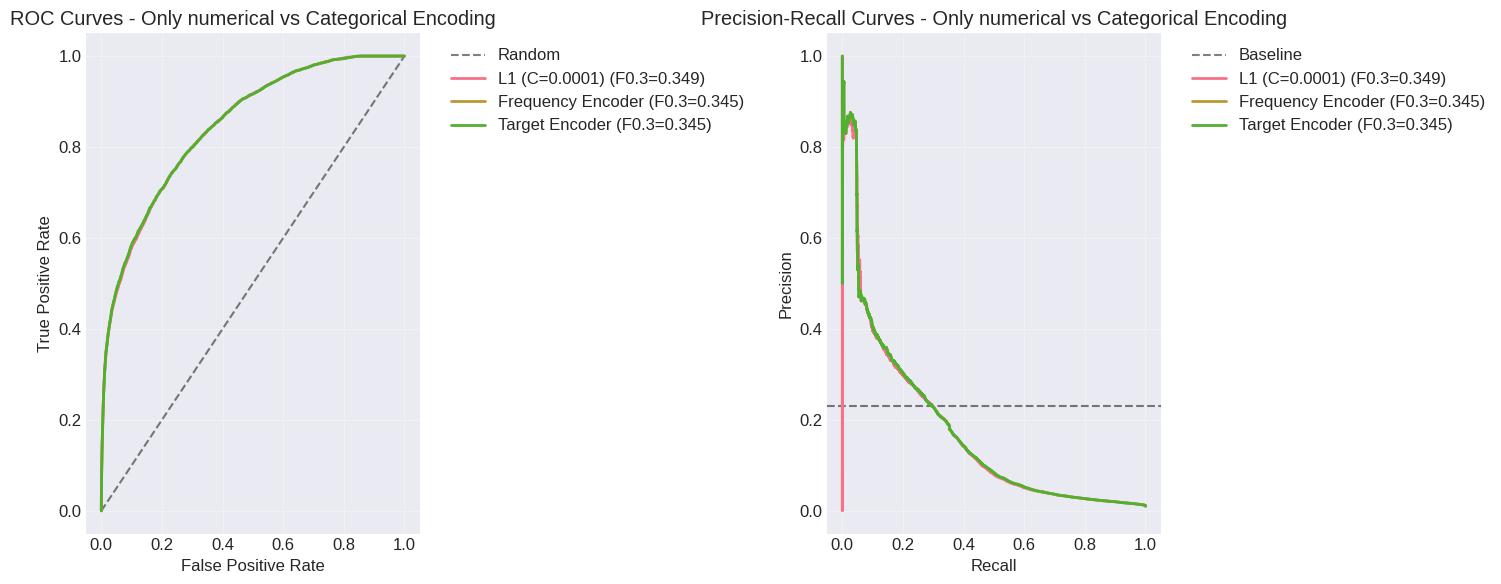

In [17]:
categorical_results = []

best_only_numercial_result = [r for r in all_results if 'L1 (C=0.0001)' in r['name']][0]
categorical_results.append(best_only_numercial_result)

for name, model in trained_categorical_models.items():
    result = evaluate_linear_model(model, X_val_cat, y_val, name)
    categorical_results.append(result)

fig1 = plot_curves_comparison(
    categorical_results, 
    "- Only numerical vs Categorical Encoding"
)
plt.show()

They haven't improved the f0.3 score. So this is our best linear model

In [18]:
linear_pipeline_features = [
    'global_popularity',
    'ordered_before',
    'abandoned_before',
    'set_as_regular'
]

linear_pipeline = Pipeline([
    ('preprocessor', ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), linear_pipeline_features)
        ],
        remainder='drop' 
    )),
    ('model', LogisticRegression(
        penalty='l1', C=0.0001, solver='liblinear', 
        max_iter=1000, random_state=random_state
    ))
])

# Non-Linear Models

I`ve explored linear models, but actualy there aren't best models to fit most data, non linear models have fits better to data

## Decision Trees

In [6]:
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree
import time
import matplotlib.pyplot as plt

MAX_DEPTH_VISUALIZATION = 5

def plot_tree_visual(
        tree_pipeline: Pipeline, feature_names, config_name
    ) -> None:

    model = tree_pipeline.named_steps['model']
    
    if model.tree_.max_depth > MAX_DEPTH_VISUALIZATION:
        plt.figure(figsize=(12, 8))
        plot_tree(model, 
                  feature_names=feature_names,
                  class_names=['0 Class', '1 Class'],
                  filled=True,
                  rounded=True,
                  max_depth=MAX_DEPTH_VISUALIZATION,
                  fontsize=8)
        plt.title(f'Decision Tree - {config_name} (first {MAX_DEPTH_VISUALIZATION} levels)', 
                  fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.show()

    else:
        plt.figure(figsize=(15, 10))
        plot_tree(model, 
                feature_names=feature_names,
                class_names=['0 Class', '1 Class'],
                filled=True,
                rounded=True,
                fontsize=10)
        plt.title(f'Decision Tree - {config_name}', fontsize=16, fontweight='bold')
        plt.tight_layout()
        plt.show()

def predict_with_threshold(model: BaseEstimator,
                           X, threshold: float = 0.5
    ) -> np.ndarray:

    y_prob = model.predict_proba(X)[:, 1]
    return (y_prob >= threshold).astype(int)


def find_best_threshold_fbeta(y_true, y_prob, beta=0.3):

    precision, recall, thr = precision_recall_curve(y_true, y_prob)
    f_beta = ((1 + beta**2) * precision * recall) / (
             beta**2 * precision + recall + 1e-12)
    best_idx = np.argmax(f_beta)
    return thr[best_idx], f_beta[best_idx]

def fit_and_evaluate_pipeline(
        pipeline, X_train, y_train, X_val, y_val, threshold=None
    ):
    
    t0 = time.time()
    pipeline.fit(X_train, y_train)
    print(f"   ⌛ fitted in {time.time()-t0:.2f}s")

    y_train_prob = pipeline.predict_proba(X_train)[:, 1]
    y_val_prob   = pipeline.predict_proba(X_val)[:, 1]

    if not threshold:
        best_thr, f_val = find_best_threshold_fbeta(y_val, y_val_prob)
    else:
        best_thr = threshold
        f_val = fbeta_03_score(y_val, (y_val_prob >= best_thr).astype(int))
        
    y_train_pred = (y_train_prob >= best_thr).astype(int)
    f_train = fbeta_03_score(y_train, y_train_pred)

    print(f"   🎯 F0.3  (train)      : {f_train:.4f}")
    print(f"   🎯 F0.3  (validation) : {f_val:.4f}")
    print(f"   🔑 Best threshold     : {best_thr:.3f}")

    return pipeline, f_train, f_val, best_thr

    


I'll make few experiments, iteratively: 
1. Pipeline (Free Tree):
    - Only best 4 features in linear models (`linear_predictive_features`)
    - Without max_depth, let the tree divide each leaf till it needs

   ⌛ fitted in 3.43s
   🎯 F0.3  (train)      : 0.5352
   🎯 F0.3  (validation) : 0.3251
   🔑 Best threshold     : 0.625


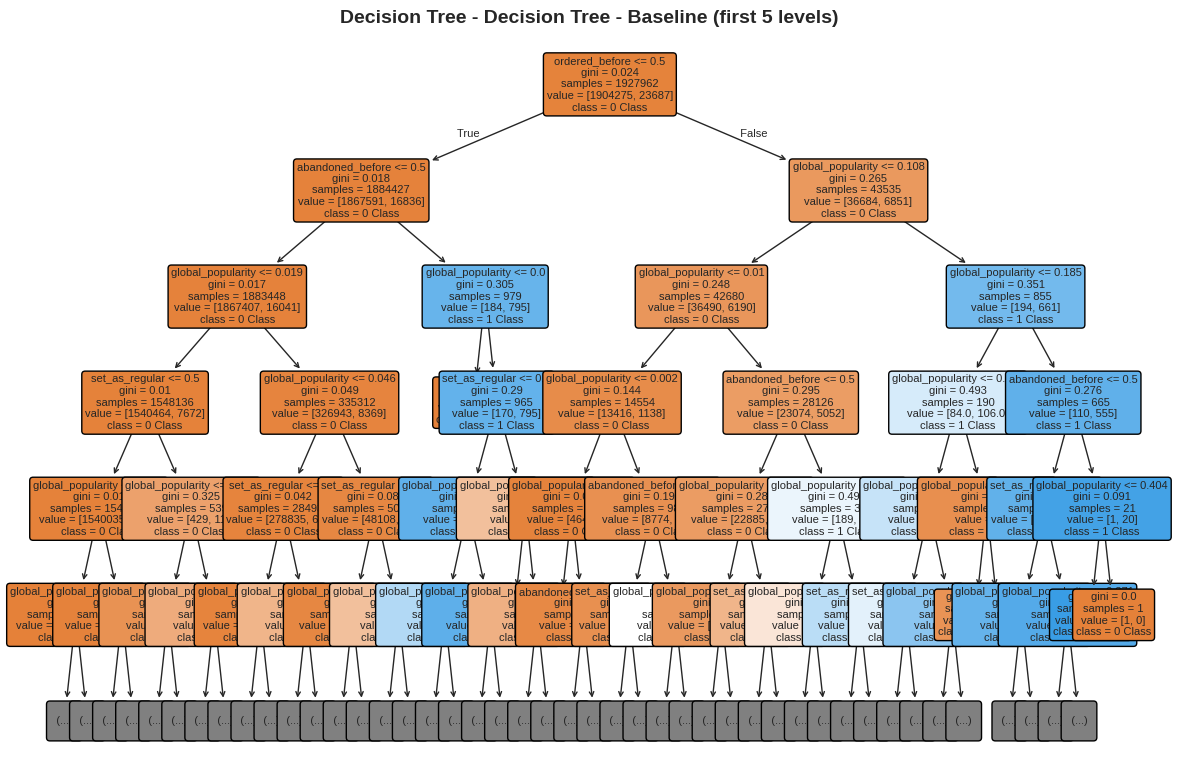

In [7]:
linear_pipeline_features = [
    'global_popularity',
    'ordered_before',
    'abandoned_before',
    'set_as_regular'
]

baseline_tree_info = {
    'name': 'Decision Tree - Baseline',
    'features': linear_pipeline_features,
    'config': {
        'max_depth': None,
        'min_samples_split': 2,
        'min_samples_leaf': 1,
        'criterion': 'gini'
    }
}


def evaluate_decision_tree_pipeline(
        X_train, y_train, X_val, y_val, tree_info
    ) -> Pipeline:
    
    pipeline = Pipeline([
        ('model', DecisionTreeClassifier(
            max_depth=tree_info['config']['max_depth'],
            criterion=tree_info['config']['criterion'],
            min_samples_split=tree_info['config']['min_samples_split'],
            min_samples_leaf=tree_info['config']['min_samples_leaf'],
            random_state=random_state
        ))
    ])

    pipeline, _, _, _ = fit_and_evaluate_pipeline(
        pipeline, X_train[tree_info['features']], y_train, 
        X_val[tree_info['features']], y_val
    )

    return pipeline
    
pipeline = evaluate_decision_tree_pipeline(X_train, y_train, X_val, y_val, baseline_tree_info)
plot_tree_visual(pipeline, 
                  baseline_tree_info['features'], 
                  baseline_tree_info['name'])

### Hyperparameter Grid Search for Decision Tree
Now we'll test different hyperparameter combinations while keeping the same 4 features that worked well in our linear model. We'll use a controlled grid search with maximum 100 iterations, ensuring logical constraints between min_samples_leaf and min_samples_split.

In [39]:
from sklearn.model_selection import ParameterGrid

def create_tree_param_grid(base_params, max_iterations):
    """Create parameter grid ensuring min_samples_leaf <= min_samples_split // 2"""
    
    all_combinations = list(ParameterGrid(base_params))
    
    # Filter out invalid combinations (min_samples_leaf > min_samples_split // 2)
    valid_combinations = []
    for params in all_combinations:
        if params['min_samples_leaf'] <= params['min_samples_split'] // 2:
            valid_combinations.append(params)
    
    if max_iterations and len(valid_combinations) > max_iterations:
        # Select diverse combinations (different max_depth values)
        selected = []
        for max_depth in base_params['max_depth']:
            depth_combos = [c for c in valid_combinations if c['max_depth'] == max_depth]
            if depth_combos and len(selected) < max_iterations:
                selected.extend(depth_combos[:max_iterations//4 + 1])
        valid_combinations = selected[:max_iterations]
    
    return valid_combinations

def run_tree_grid_search(X_train, y_train, X_val, y_val, features, base_params, max_iterations):
    
    param_combinations = create_tree_param_grid(base_params, max_iterations)
    
    print(f"Testing {len(param_combinations)} hyperparameter combinations:")
    print("=" * 80)
    
    results = []
    
    for i, params in enumerate(param_combinations, 1):
        print(f"\n[{i}/{len(param_combinations)}] Testing configuration:")
        print(f"  max_depth={params['max_depth']}, criterion={params['criterion']}")
        print(f"  min_samples_split={params['min_samples_split']}, min_samples_leaf={params['min_samples_leaf']}")
        
        # Evaluate (suppress individual prints)
        pipeline = Pipeline([
            ('model', DecisionTreeClassifier(
                max_depth=params['max_depth'],
                criterion=params['criterion'],
                min_samples_split=params['min_samples_split'],
                min_samples_leaf=params['min_samples_leaf'],
                random_state=random_state
            ))
        ])
        
        pipeline, f03_score_train, f03_score_val, best_threshold = fit_and_evaluate_pipeline(
            pipeline, X_train[features], y_train, 
            X_val[features], y_val
        )
                
        result = {
            'config_id': i,
            'max_depth': params['max_depth'],
            'criterion': params['criterion'],
            'min_samples_split': params['min_samples_split'],
            'min_samples_leaf': params['min_samples_leaf'],
            'f03_train': f03_score_train,
            'f03_val': f03_score_val,
            'threshold': best_threshold,
            'overfitting': f03_score_train - f03_score_val,
            'pipeline': pipeline
        }
        results.append(result)
    
    results_df = pd.DataFrame(results)
    
    print(f"\n{'='*80}")
    print("TOP 5 CONFIGURATIONS BY VALIDATION F0.3:")
    print("="*80)
    
    top_results = results_df.nlargest(5, 'f03_val')
    print(f"{'Rank':<4} {'Config':<7} {'max_depth':<10} {'criterion':<9} {'min_split':<10} {'min_leaf':<9} {'Val F0.3':<8} {'Overfitting'}")
    print("-" * 80)
    
    for rank, (_, row) in enumerate(top_results.iterrows(), 1):
        print(f"{rank:<4} #{row['config_id']:<6} {str(row['max_depth']):<10} {row['criterion']:<9} "
              f"{row['min_samples_split']:<10} {row['min_samples_leaf']:<9} {row['f03_val']:<8.4f} {row['overfitting']:>+.4f}")
    
    best_config = results_df.loc[results_df['f03_val'].idxmax()]
    
    print(f"\n{'='*80}")
    print("BEST CONFIGURATION:")
    print("="*80)
    print(f"Config #{best_config['config_id']}:")
    print(f"  max_depth: {best_config['max_depth']}")
    print(f"  criterion: {best_config['criterion']}")  
    print(f"  min_samples_split: {best_config['min_samples_split']}")
    print(f"  min_samples_leaf: {best_config['min_samples_leaf']}")
    print(f"  Validation F0.3: {best_config['f03_val']:.4f}")
    print(f"  Training F0.3: {best_config['f03_train']:.4f}")
    print(f"  Best Threshold: {best_config['threshold']:.3f}")
    print(f"  Overfitting: {best_config['overfitting']:+.4f}")
    
    return results_df, best_config

print("DECISION TREE - HYPERPARAMETER GRID SEARCH")
print("Features:", linear_pipeline_features)


base_params = {
    'max_depth': [3, 6, 10, 15],
    'criterion': ['gini', 'entropy'],
    'min_samples_split': [2000, 500, 100, 50],
    'min_samples_leaf': [300, 100, 75, 40, 5]
}

grid_results, best_tree_config = run_tree_grid_search(
    X_train, y_train, X_val, y_val, 
    linear_pipeline_features, base_params,
    max_iterations=100
)

DECISION TREE - HYPERPARAMETER GRID SEARCH
Features: ['global_popularity', 'ordered_before', 'abandoned_before', 'set_as_regular']
Testing 96 hyperparameter combinations:

[1/96] Testing configuration:
  max_depth=3, criterion=gini
  min_samples_split=2000, min_samples_leaf=300
   ⌛ fitted in 0.47s
   🎯 F0.3  (train)      : 0.4002
   🎯 F0.3  (validation) : 0.3914
   🔑 Best threshold     : 0.773

[2/96] Testing configuration:
  max_depth=3, criterion=gini
  min_samples_split=2000, min_samples_leaf=100
   ⌛ fitted in 0.39s
   🎯 F0.3  (train)      : 0.4002
   🎯 F0.3  (validation) : 0.3914
   🔑 Best threshold     : 0.773

[3/96] Testing configuration:
  max_depth=3, criterion=gini
  min_samples_split=500, min_samples_leaf=100
   ⌛ fitted in 0.41s
   🎯 F0.3  (train)      : 0.4002
   🎯 F0.3  (validation) : 0.3914
   🔑 Best threshold     : 0.558

[4/96] Testing configuration:
  max_depth=3, criterion=gini
  min_samples_split=2000, min_samples_leaf=75
   ⌛ fitted in 0.41s
   🎯 F0.3  (train)   

Based on the grid search results, we can see some patterns in the optimal hyperparameters:

- max_depth: Around 6-15
- criterion: entropy consistently outperforms gini
- min_samples_split: 100-500 range works best
- min_samples_leaf: 40-100 range shows best validation scores with low overfitting

`max_depth=10`, `criterion=entropy`, `min_samples_split=100`, `min_samples_leaf=40` provides the optimal balance of performance and computational efficiency. `F0.3 score = 0.4094`

Now we'll use Random Search to explore these promising ranges more thoroughly and potentially find better combinations.

In [40]:
def run_tree_random_search(X_train, y_train, X_val, y_val, features, param_distributions, n_iterations=100):
    
    print(f"DECISION TREE - RANDOM SEARCH REFINEMENT")
    print(f"Features: {features}")
    print(f"Random iterations: {n_iterations}")
    print(f"Parameter ranges:")
    for param, values in param_distributions.items():
        if isinstance(values, np.ndarray):
            print(f"  {param}: {values.min()}-{values.max()}")
        else:
            print(f"  {param}: {values}")
    
    print("\n" + "="*80)
    
    valid_combinations = []
    np.random.seed(random_state)
    
    attempts = 0
    while len(valid_combinations) < n_iterations and attempts < n_iterations * 3:
        params = {}
        for param, values in param_distributions.items():
            if isinstance(values, np.ndarray):
                params[param] = np.random.choice(values)
            else:
                params[param] = np.random.choice(values)
        
        if params['min_samples_leaf'] <= params['min_samples_split'] // 2:
            if params not in valid_combinations:
                valid_combinations.append(params)
        
        attempts += 1
    
    print(f"Generated {len(valid_combinations)} valid random combinations:\n")
    
    results = []
    
    for i, params in enumerate(valid_combinations, 1):
        print(f"[{i}/{len(valid_combinations)}] Testing:")
        print(f"  max_depth={params['max_depth']}, criterion={params['criterion']}")
        print(f"  min_samples_split={params['min_samples_split']}, min_samples_leaf={params['min_samples_leaf']}")
        
        pipeline = Pipeline([
            ('model', DecisionTreeClassifier(
                max_depth=params['max_depth'],
                criterion=params['criterion'],
                min_samples_split=params['min_samples_split'],
                min_samples_leaf=params['min_samples_leaf'],
                random_state=random_state
            ))
        ])
        
        pipeline, f03_score_train, f03_score_val, best_threshold = fit_and_evaluate_pipeline(
            pipeline, X_train[features], y_train, 
            X_val[features], y_val
        )
        
        result = {
            'config_id': f'RS_{i}',
            'max_depth': params['max_depth'],
            'criterion': params['criterion'],
            'min_samples_split': params['min_samples_split'],
            'min_samples_leaf': params['min_samples_leaf'],
            'f03_train': f03_score_train,
            'f03_val': f03_score_val,
            'threshold': best_threshold,
            'overfitting': f03_score_train - f03_score_val,
            'pipeline': pipeline
        }
        results.append(result)
    
    results_df = pd.DataFrame(results)
    
    print(f"\n{'='*80}")
    print("TOP 5 RANDOM SEARCH RESULTS:")
    print("="*80)
    
    top_results = results_df.nlargest(5, 'f03_val')
    print(f"{'Rank':<4} {'Config':<8} {'max_depth':<10} {'criterion':<9} {'min_split':<10} {'min_leaf':<9} {'Val F0.3':<8} {'Overfitting'}")
    print("-" * 85)
    
    for rank, (_, row) in enumerate(top_results.iterrows(), 1):
        print(f"{rank:<4} {row['config_id']:<8} {str(row['max_depth']):<10} {row['criterion']:<9} "
              f"{row['min_samples_split']:<10} {row['min_samples_leaf']:<9} {row['f03_val']:<8.4f} {row['overfitting']:>+.4f}")
    
    best_random = results_df.loc[results_df['f03_val'].idxmax()]
    
    print(f"\n{'='*80}")
    print("BEST RANDOM SEARCH RESULT:")
    print("="*80)
    print(f"Config {best_random['config_id']}:")
    print(f"  max_depth: {best_random['max_depth']}")
    print(f"  criterion: {best_random['criterion']}")
    print(f"  min_samples_split: {best_random['min_samples_split']}")
    print(f"  min_samples_leaf: {best_random['min_samples_leaf']}")
    print(f"  Validation F0.3: {best_random['f03_val']:.4f}")
    print(f"  Training F0.3: {best_random['f03_train']:.4f}")
    print(f"  Best Threshold: {best_random['threshold']:.3f}")
    print(f"  Overfitting: {best_random['overfitting']:+.4f}")
    
    print(f"\n{'='*80}")
    print(f"COMPARISON: Random Search vs Grid Search")
    print("="*80)
    print(f"Best Grid Search    F0.3: {best_tree_config['f03_val']:.4f}")
    print(f"Best Random Search  F0.3: {best_random['f03_val']:.4f}")
    improvement = best_random['f03_val'] - best_tree_config['f03_val']
    print(f"Improvement: {improvement:+.4f} ({improvement/best_tree_config['f03_val']*100:+.2f}%)")
    
    return results_df, best_random

param_distributions = {
    'max_depth': np.arange(6, 20, 1),
    'criterion': ['entropy', 'gini'],
    'min_samples_split': np.arange(80, 600, 10),
    'min_samples_leaf': np.arange(30, 150, 5)
}

random_results, best_random_config = run_tree_random_search(
    X_train, y_train, X_val, y_val, 
    linear_pipeline_features, param_distributions,
    n_iterations=200
)

DECISION TREE - RANDOM SEARCH REFINEMENT
Features: ['global_popularity', 'ordered_before', 'abandoned_before', 'set_as_regular']
Random iterations: 200
Parameter ranges:
  max_depth: 6-19
  criterion: ['entropy', 'gini']
  min_samples_split: 80-590
  min_samples_leaf: 30-145

Generated 200 valid random combinations:

[1/200] Testing:
  max_depth=19, criterion=entropy
  min_samples_split=470, min_samples_leaf=70
   ⌛ fitted in 1.53s
   🎯 F0.3  (train)      : 0.4229
   🎯 F0.3  (validation) : 0.4034
   🔑 Best threshold     : 0.462
[2/200] Testing:
  max_depth=19, criterion=gini
  min_samples_split=450, min_samples_leaf=145
   ⌛ fitted in 1.63s
   🎯 F0.3  (train)      : 0.4192
   🎯 F0.3  (validation) : 0.4041
   🔑 Best threshold     : 0.452
[3/200] Testing:
  max_depth=11, criterion=gini
  min_samples_split=410, min_samples_leaf=140
   ⌛ fitted in 1.29s
   🎯 F0.3  (train)      : 0.4192
   🎯 F0.3  (validation) : 0.4041
   🔑 Best threshold     : 0.452
[4/200] Testing:
  max_depth=6, criterio

We've successfully found an optimal decision tree using the same 4 features from our linear model baseline. The hyperparameter search results show:

- Grid Search identified the best configuration: `max_depth=10`, `criterion=entropy`, `min_samples_split=100`, `min_samples_leaf=40` achieving **F0.3 = 0.4094**
- Random Search refinement didn't find significantly better combinations, confirming our grid search was thorough in the promising parameter space achieving **F0.3 = 0.4121**
- Non-linear improvement: Decision tree (0.4121) substantially outperforms our linear baseline (0.4094), representing a +0.66% improvement

This validates that the relationships in our data have non-linear patterns that trees can capture better than linear models, even with the same feature set.

Now we'll expand our feature set to test whether additional variables can further improve upon this `0.4121 F0.3 score`, moving from our curated 4-feature baseline to exploring the full feature space.

In [7]:
target = "outcome"
cols_to_drop = ["variant_id", "user_id", "order_date", "items_bought"]
all_feature_cols = sales_df.columns[~sales_df.columns.isin(cols_to_drop + [target])]

numeric_cols = sales_df[all_feature_cols].select_dtypes(include=[np.number]).columns.tolist()
numeric_cols.remove('order_id')
categorical_cols = sales_df[all_feature_cols].select_dtypes(exclude=[np.number]).columns.tolist()
categorical_cols.remove('created_at')

print("Numeric columns:", numeric_cols)
print("Categorical columns:", categorical_cols)

Numeric columns: ['user_order_seq', 'ordered_before', 'abandoned_before', 'active_snoozed', 'set_as_regular', 'normalised_price', 'discount_pct', 'global_popularity', 'count_adults', 'count_children', 'count_babies', 'count_pets', 'people_ex_baby', 'days_since_purchase_variant_id', 'avg_days_to_buy_variant_id', 'std_days_to_buy_variant_id', 'days_since_purchase_product_type', 'avg_days_to_buy_product_type', 'std_days_to_buy_product_type']
Categorical columns: ['product_type', 'vendor']


**All numerical features:**

1. Free Tree (without stop criterion)

In [9]:
baseline_tree_info = {
    'name': 'Decision Tree - All Numeric Features',
    'features': numeric_cols,
    'config': {
        'max_depth': None,
        'min_samples_split': 2,
        'min_samples_leaf': 1,
        'criterion': 'gini'
    }
}
pipeline = evaluate_decision_tree_pipeline(X_train, y_train, X_val, y_val, baseline_tree_info)

   ⌛ fitted in 13.29s
   🎯 F0.3  (train)      : 0.9495
   🎯 F0.3  (validation) : 0.1282
   🔑 Best threshold     : 1.000


A lot of overfitting. Low bias but high variance!! Let's regularize it, adjusting hiperparameters

We have more features, so we should let the model have more flexibility

In [43]:
param_distributions = {
    'max_depth': np.arange(6, 40, 2),
    'criterion': ['entropy', 'gini'],
    'min_samples_split': np.arange(80, 600, 10),
    'min_samples_leaf': np.arange(30, 150, 5)
}

random_results, best_random_config = run_tree_random_search(
    X_train, y_train, X_val, y_val, 
    numeric_cols, param_distributions,
    n_iterations=100
)

DECISION TREE - RANDOM SEARCH REFINEMENT
Features: ['user_order_seq', 'ordered_before', 'abandoned_before', 'active_snoozed', 'set_as_regular', 'normalised_price', 'discount_pct', 'global_popularity', 'count_adults', 'count_children', 'count_babies', 'count_pets', 'people_ex_baby', 'days_since_purchase_variant_id', 'avg_days_to_buy_variant_id', 'std_days_to_buy_variant_id', 'days_since_purchase_product_type', 'avg_days_to_buy_product_type', 'std_days_to_buy_product_type']
Random iterations: 100
Parameter ranges:
  max_depth: 6-38
  criterion: ['entropy', 'gini']
  min_samples_split: 80-590
  min_samples_leaf: 30-145

Generated 100 valid random combinations:

[1/100] Testing:
  max_depth=32, criterion=entropy
  min_samples_split=470, min_samples_leaf=70
   ⌛ fitted in 7.95s
   🎯 F0.3  (train)      : 0.4273
   🎯 F0.3  (validation) : 0.4146
   🔑 Best threshold     : 0.480
[2/100] Testing:
  max_depth=16, criterion=gini
  min_samples_split=450, min_samples_leaf=35
   ⌛ fitted in 6.43s
   🎯

Based on the random search results with all numerical features:

- More numerical features, better result
- `max_depth=14`, `criterion=entropy`, `min_samples_split=190`, `min_samples_leaf=60` provides the optimal balance of performance and computational efficiency.

After testing with all numeric features, we achieved an F0.3 score of **0.4253** compared to **0.4121** with just 4 features - an improvement of only **+0.0132 (+3.1%)**.

- Does 3.1% gain justify the complexity increase?
- More features increase the chance of learning noise
- 4-feature model is more interpretable and maintainable
- Faster to train and tune with fewer features
- Simpler models often generalize better to new data

The 4 core features (global_popularity, ordered_before, abandoned_before, set_as_regular) capture the essential patterns effectively without adding unnecessary complexity.

Let's see now what about categorical features:


In [8]:
class DateFeatureTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, date_column="created_at"):
        self.date_column = date_column
        self.date_feature_names = ["year", "doy"]

    def fit(self, X, y=None):
        self.feature_names_in_ = X.columns.to_list()
        return self

    def transform(self, X):
        Xc = X.copy()

        dates = pd.to_datetime(Xc[self.date_column], errors="coerce")

        Xc["year"] = dates.dt.year.astype("int16")
        Xc["doy"]  = dates.dt.dayofyear.astype("int16")

        return Xc.drop(columns=[self.date_column])

    def get_feature_names_out(self, input_features=None):
        if input_features is None:
            input_features = self.feature_names_in_
        return np.array(
            [f for f in input_features if f != self.date_column] + self.date_feature_names
        )


class FrequencyEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, categorical_columns, dtype="float32", unknown_strategy="min"):
        self.categorical_columns = categorical_columns
        self.dtype = dtype
        self.unknown_strategy = unknown_strategy
        self.frequency_maps_: dict[str, pd.Series] = {}
        self.default_: dict[str, float] = {}

    def fit(self, X, y=None):
        self.feature_names_in_ = X.columns.to_list()

        for col in self.categorical_columns:
            if col not in X.columns:
                continue

            s = X[col].astype("category")
            freq = s.value_counts(normalize=True)

            self.frequency_maps_[col] = freq.astype(self.dtype)

            if self.unknown_strategy == "min":
                self.default_[col] = freq.min()
            elif self.unknown_strategy == "zero":
                self.default_[col] = 0.0
            else:  # user supplied literal
                self.default_[col] = float(self.unknown_strategy)

        return self

    def transform(self, X):
        Xc = X.copy(deep=False)

        for col, fmap in self.frequency_maps_.items():
            if col not in Xc.columns:
                continue

            Xc[col] = (
                Xc[col]
                .map(fmap)                               
                .fillna(self.default_[col])              
                .astype(self.dtype, copy=False)          
            )

        return Xc

    def get_feature_names_out(self, input_features=None):
        return (
            np.array(input_features)
            if input_features is not None
            else np.array(self.feature_names_in_)
        )



In [47]:
def run_categorical_tree_random_search(
        X_train, y_train, X_val, y_val, 
        numerical_features, categorical_features,
        param_distributions, n_iterations=100
    ):
    
    print(f"DECISION TREE (all features) - RANDOM SEARCH REFINEMENT")
    features = numerical_features + categorical_features + ['created_at']
    print(f"Features: {features}")
    print(f"Random iterations: {n_iterations}")
    print(f"Parameter ranges:")
    for param, values in param_distributions.items():
        if isinstance(values, np.ndarray):
            print(f"  {param}: {values.min()}-{values.max()}")
        else:
            print(f"  {param}: {values}")
    
    print("\n" + "="*80)
    
    valid_combinations = []
    np.random.seed(random_state)
    
    attempts = 0
    while len(valid_combinations) < n_iterations and attempts < n_iterations * 3:
        params = {}
        for param, values in param_distributions.items():
            if isinstance(values, np.ndarray):
                params[param] = np.random.choice(values)
            else:
                params[param] = np.random.choice(values)
        
        if params['min_samples_leaf'] <= params['min_samples_split'] // 2:
            if params not in valid_combinations:
                valid_combinations.append(params)
        
        attempts += 1
    
    print(f"Generated {len(valid_combinations)} valid random combinations:\n")
    
    results = []
    
    for i, params in enumerate(valid_combinations, 1):
        print(f"[{i}/{len(valid_combinations)}] Testing:")
        print(f"  max_depth={params['max_depth']}, criterion={params['criterion']}")
        print(f"  min_samples_split={params['min_samples_split']}, min_samples_leaf={params['min_samples_leaf']}")
    
        preprocessor = ColumnTransformer(
            transformers=[
                ('num', 'passthrough', numerical_features),
                ('cat', FrequencyEncoder(categorical_features), categorical_features),
                ('date', DateFeatureTransformer(), ['created_at'])
            ],
            remainder='drop'  # Drop any other columns not specified
        )

        pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('model', DecisionTreeClassifier(
                max_depth=params['max_depth'],
                criterion=params['criterion'],
                min_samples_split=params['min_samples_split'],
                min_samples_leaf=params['min_samples_leaf'],
                random_state=random_state
            ))
        ])
        
        pipeline, f03_score_train, f03_score_val, threshold = fit_and_evaluate_pipeline(
            pipeline, X_train[features], y_train, 
            X_val[features], y_val
        )
        
        result = {
            'config_id': f'RS_{i}',
            'max_depth': params['max_depth'],
            'criterion': params['criterion'],
            'min_samples_split': params['min_samples_split'],
            'min_samples_leaf': params['min_samples_leaf'],
            'f03_train': f03_score_train,
            'f03_val': f03_score_val,
            'threshold': threshold,
            'overfitting': f03_score_train - f03_score_val,
            'pipeline': pipeline
        }
        results.append(result)
    
    results_df = pd.DataFrame(results)
    
    print(f"\n{'='*80}")
    print("TOP 5 RANDOM SEARCH RESULTS:")
    print("="*80)
    
    top_results = results_df.nlargest(5, 'f03_val')
    print(f"{'Rank':<4} {'Config':<8} {'max_depth':<10} {'criterion':<9} {'min_split':<10} {'min_leaf':<9} {'Val F0.3':<8} {'Overfitting'}")
    print("-" * 85)
    
    for rank, (_, row) in enumerate(top_results.iterrows(), 1):
        print(f"{rank:<4} {row['config_id']:<8} {str(row['max_depth']):<10} {row['criterion']:<9} "
              f"{row['min_samples_split']:<10} {row['min_samples_leaf']:<9} {row['f03_val']:<8.4f} {row['overfitting']:>+.4f}")
    
    best_random = results_df.loc[results_df['f03_val'].idxmax()]
    
    print(f"\n{'='*80}")
    print("BEST RANDOM SEARCH RESULT:")
    print("="*80)
    print(f"Config {best_random['config_id']}:")
    print(f"  max_depth: {best_random['max_depth']}")
    print(f"  criterion: {best_random['criterion']}")
    print(f"  min_samples_split: {best_random['min_samples_split']}")
    print(f"  min_samples_leaf: {best_random['min_samples_leaf']}")
    print(f"  Validation F0.3: {best_random['f03_val']:.4f}")
    print(f"  Training F0.3: {best_random['f03_train']:.4f}")
    print(f"  Best Threshold: {best_random['threshold']:.3f}")
    print(f"  Overfitting: {best_random['overfitting']:+.4f}")
    
    print(f"\n{'='*80}")
    print(f"Best Random Search  F0.3: {best_random['f03_val']:.4f}")

    return results_df, best_random

param_distributions = {
    'max_depth': np.arange(5, 25, 1),
    'criterion': ['entropy', 'gini'],
    'min_samples_split': np.arange(80, 600, 10),
    'min_samples_leaf': np.arange(30, 150, 5)
}

random_results, best_random_config = run_categorical_tree_random_search(
    X_train, y_train, X_val, y_val, 
    linear_pipeline_features, categorical_cols, 
    param_distributions, n_iterations=60
)

DECISION TREE (all features) - RANDOM SEARCH REFINEMENT
Features: ['global_popularity', 'ordered_before', 'abandoned_before', 'set_as_regular', 'product_type', 'vendor', 'created_at']
Random iterations: 60
Parameter ranges:
  max_depth: 5-24
  criterion: ['entropy', 'gini']
  min_samples_split: 80-590
  min_samples_leaf: 30-145

Generated 60 valid random combinations:

[1/60] Testing:
  max_depth=18, criterion=entropy
  min_samples_split=470, min_samples_leaf=70
   ⌛ fitted in 5.56s
   🎯 F0.3  (train)      : 0.4267
   🎯 F0.3  (validation) : 0.4076
   🔑 Best threshold     : 0.462
[2/60] Testing:
  max_depth=10, criterion=gini
  min_samples_split=450, min_samples_leaf=35
   ⌛ fitted in 4.42s
   🎯 F0.3  (train)      : 0.4277
   🎯 F0.3  (validation) : 0.4093
   🔑 Best threshold     : 0.419
[3/60] Testing:
  max_depth=21, criterion=gini
  min_samples_split=540, min_samples_leaf=95
   ⌛ fitted in 6.71s
   🎯 F0.3  (train)      : 0.4211
   🎯 F0.3  (validation) : 0.4083
   🔑 Best threshold     

No improvement, so we are getting with our Tree Baseline model with only four features

I'll continue with more no linear models:
- Ensemble Methods
    - Random Forest
    - Gradient Boosting

- Especialized Models
    - SVM
    - K-Nearest Neighbors

- Neural Networks


## Random Forest

I will see what happens with a Random Forest with all numerical features.


Testing max_depth = 6
----------------------------------------
Training Random Forest with 10 estimators, max_depth=6...
   ⌛ fitted in 3.80s
   🎯 F0.3  (train)      : 0.4305
   🎯 F0.3  (validation) : 0.4188
   🔑 Best threshold     : 0.236
Training Random Forest with 50 estimators, max_depth=6...
   ⌛ fitted in 15.20s
   🎯 F0.3  (train)      : 0.4351
   🎯 F0.3  (validation) : 0.4339
   🔑 Best threshold     : 0.223
Training Random Forest with 100 estimators, max_depth=6...
   ⌛ fitted in 28.32s
   🎯 F0.3  (train)      : 0.4382
   🎯 F0.3  (validation) : 0.4337
   🔑 Best threshold     : 0.241
Training Random Forest with 200 estimators, max_depth=6...
   ⌛ fitted in 53.94s
   🎯 F0.3  (train)      : 0.4408
   🎯 F0.3  (validation) : 0.4385
   🔑 Best threshold     : 0.245

Testing max_depth = 10
----------------------------------------
Training Random Forest with 10 estimators, max_depth=10...
   ⌛ fitted in 4.17s
   🎯 F0.3  (train)      : 0.4618
   🎯 F0.3  (validation) : 0.4086
   🔑 Best th

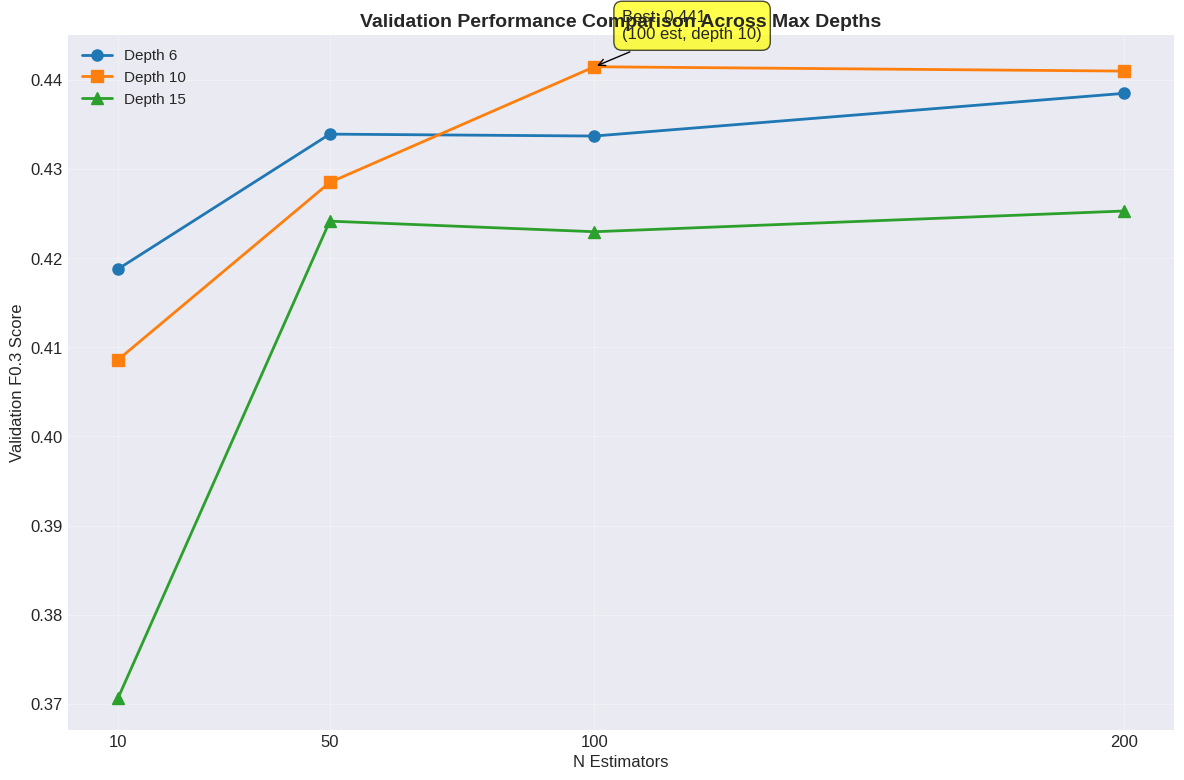


Best configuration: 100 estimators, max_depth=10 -> F0.3: 0.4415 


In [12]:
from sklearn.ensemble import RandomForestClassifier

n_estimators_list = [10, 50, 100, 200]
max_depths = [6, 10, 15]

results = {}

for max_depth in max_depths:
    print(f"\nTesting max_depth = {max_depth}")
    print("-" * 40)
    
    f03_train_scores = []
    f03_val_scores = []
    
    for n_estimators in n_estimators_list:
        print(f"Training Random Forest with {n_estimators} estimators, max_depth={max_depth}...")
        
        rf_pipeline = Pipeline([
            ('model', RandomForestClassifier(
                n_estimators=n_estimators,
                max_depth=max_depth,
                n_jobs=-1,
                random_state=random_state
            ))
        ])
        
        rf_pipeline, f03_train, f03_val, best_threshold = fit_and_evaluate_pipeline(
            rf_pipeline, X_train[numeric_cols], y_train,
            X_val[numeric_cols], y_val
        )
        
        f03_train_scores.append(f03_train)
        f03_val_scores.append(f03_val)
    
    results[max_depth] = {
        'train': f03_train_scores,
        'val': f03_val_scores
    }

plt.figure(figsize=(12, 8))

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
markers = ['o', 's', '^', 'D']

for i, max_depth in enumerate(max_depths):
    depth_label = "Unlimited" if max_depth is None else f"Depth {max_depth}"
    plt.plot(n_estimators_list, results[max_depth]['val'], 
             color=colors[i], marker=markers[i], label=f'{depth_label}', 
             linewidth=2, markersize=8)

plt.xlabel('N Estimators', fontsize=12)
plt.ylabel('Validation F0.3 Score', fontsize=12)
plt.title('Validation Performance Comparison Across Max Depths', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.xticks(n_estimators_list)

best_score = 0
best_config = None
for max_depth in max_depths:
    max_score = max(results[max_depth]['val'])
    if max_score > best_score:
        best_score = max_score
        best_idx = results[max_depth]['val'].index(max_score)
        best_config = (n_estimators_list[best_idx], max_depth)

if best_config:
    depth_label = "Unlimited" if best_config[1] is None else best_config[1]
    plt.annotate(f'Best: {best_score:.3f}\n({best_config[0]} est, depth {depth_label})', 
                xy=(best_config[0], best_score), xytext=(20, 20),
                textcoords='offset points', ha='left',
                bbox=dict(boxstyle='round,pad=0.5', facecolor='yellow', alpha=0.7),
                arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))

plt.tight_layout()
plt.show()

print(f"\nBest configuration: {best_config[0]} estimators, max_depth={best_config[1]} -> F0.3: {best_score:.4f} ")

Now a random search

In [12]:
from sklearn.ensemble import RandomForestClassifier

n_trials = 20
best_score = 0
best_params = {}

n_estimators_range = [80, 90, 100, 110, 120, 130, 140, 150]
max_depth_range = [5, 6, 7, 8, 9, 10, 11, 12]

print("Random Search (numerical cols) - Random Forest Optimization")
print("=" * 50)

for trial in range(n_trials):
    params = {
        'n_estimators': random.choice(n_estimators_range),
        'max_depth': random.choice(max_depth_range),
        'random_state': random_state,
        'n_jobs': -1
    }

    print(f"Trial {trial+1:2d}: n_est={params['n_estimators']:3d}, depth={params['max_depth']:2d}")
    
    rf = RandomForestClassifier(**params)

    rf, f03_train, f03_val, _ = fit_and_evaluate_pipeline(
        rf, X_train[numeric_cols], y_train,
        X_val[numeric_cols], y_val
    )
    
    if f03_val > best_score:
        best_score = f03_val
        best_params = params.copy()

print("\n" + "=" * 50)
print("BEST CONFIG:")
print(f"F0.3 Score: {best_score:.4f}")
for param, value in best_params.items():
    if param != 'n_jobs':
        print(f"{param}: {value}")

final_rf = RandomForestClassifier(**best_params)

final_rf, f03_train_final, f03_val_final, threshold = fit_and_evaluate_pipeline(
    final_rf, X_train[numeric_cols], y_train,
    X_val[numeric_cols], y_val
)

print(f"\nFinal Results:")
print(f"Train F0.3: {f03_train_final:.4f}")
print(f"Val F0.3:   {f03_val_final:.4f}")
print(f"Threshold: {threshold:.4f}")

Random Search (numerical cols) - Random Forest Optimization
Trial  1: n_est=110, depth=12
   ⌛ fitted in 48.00s
   🎯 F0.3  (train)      : 0.5067
   🎯 F0.3  (validation) : 0.4282
   🔑 Best threshold     : 0.439
Trial  2: n_est=150, depth= 8
   ⌛ fitted in 49.58s
   🎯 F0.3  (train)      : 0.4596
   🎯 F0.3  (validation) : 0.4392
   🔑 Best threshold     : 0.322
Trial  3: n_est=110, depth= 9
   ⌛ fitted in 39.51s
   🎯 F0.3  (train)      : 0.4774
   🎯 F0.3  (validation) : 0.4389
   🔑 Best threshold     : 0.309
Trial  4: n_est= 80, depth= 8
   ⌛ fitted in 27.71s
   🎯 F0.3  (train)      : 0.4591
   🎯 F0.3  (validation) : 0.4365
   🔑 Best threshold     : 0.330
Trial  5: n_est= 80, depth= 8
   ⌛ fitted in 27.66s
   🎯 F0.3  (train)      : 0.4591
   🎯 F0.3  (validation) : 0.4365
   🔑 Best threshold     : 0.330
Trial  6: n_est=140, depth=11
   ⌛ fitted in 56.82s
   🎯 F0.3  (train)      : 0.5021
   🎯 F0.3  (validation) : 0.4403
   🔑 Best threshold     : 0.379
Trial  7: n_est= 80, depth= 8
   ⌛ fitte

So the best random forest model (only numerical features) has ``0.4415 f0.3 score``
- ``n_estimators=100``
- ``max_depth=10``

Now lets see how RF performs with all the features available (numerical + categorical)

In [10]:
from sklearn.ensemble import RandomForestClassifier

np.random.seed(random_state)

n_trials = 20
best_score = 0
best_params = {}

n_estimators_range = [80, 90, 100, 110, 120, 130, 140, 150]
max_depth_range = [5, 6, 7, 8, 9, 10, 11, 12]
all_features = numeric_cols + categorical_cols + ['created_at']

print("Random Search (all features) - Random Forest Optimization")
print("=" * 50)

for trial in range(n_trials):
    params = {
        'n_estimators': random.choice(n_estimators_range),
        'max_depth': random.choice(max_depth_range),
        'random_state': random_state,
        'n_jobs': -1
    }
    
    print(f"Trial {trial+1:2d}: n_est={params['n_estimators']:3d}, depth={params['max_depth']:2d}")


    pipeline = Pipeline([
        ('preprocessor', ColumnTransformer(
            transformers=[
                ('num', 'passthrough', numeric_cols),
                ('cat', FrequencyEncoder(categorical_cols), categorical_cols),
                ('date', DateFeatureTransformer(), ['created_at'])
            ],
            remainder='drop'
        )),
        ('model', RandomForestClassifier(**params))
    ])

    pipeline, f03_train, f03_val, _ = fit_and_evaluate_pipeline(
        pipeline, X_train, y_train,
        X_val, y_val
    )
        
    if f03_val > best_score:
        best_score = f03_val
        best_params = params.copy()

print("\n" + "=" * 50)
print("BEST CONFIG:")
print(f"F0.3 Score: {best_score:.4f}")
for param, value in best_params.items():
    if param != 'n_jobs':
        print(f"{param}: {value}")

final_pipeline = Pipeline([
    ('preprocessor', ColumnTransformer(
        transformers=[
            ('num', 'passthrough', numeric_cols),
            ('cat', FrequencyEncoder(categorical_cols), categorical_cols),
            ('date', DateFeatureTransformer(), ['created_at'])
        ],
        remainder='drop' 
    )),
    ('model', RandomForestClassifier(**best_params))
])

final_pipeline, f03_train_final, f03_val_final, threshold = fit_and_evaluate_pipeline(
    final_pipeline, X_train, y_train,
    X_val, y_val
)

print(f"\nFinal Results:")
print(f"Train F0.3: {f03_train_final:.4f}")
print(f"Val F0.3:   {f03_val_final:.4f}")
print(f"Best Threshold: {threshold:.3f}")

Random Search (all features) - Random Forest Optimization
Trial  1: n_est=140, depth=11
   ⌛ fitted in 65.51s
   🎯 F0.3  (train)      : 0.4740
   🎯 F0.3  (validation) : 0.4124
   🔑 Best threshold     : 0.487
Trial  2: n_est=130, depth= 9
   ⌛ fitted in 51.04s
   🎯 F0.3  (train)      : 0.4786
   🎯 F0.3  (validation) : 0.4404
   🔑 Best threshold     : 0.326
Trial  3: n_est= 90, depth=12
   ⌛ fitted in 47.26s
   🎯 F0.3  (train)      : 0.4898
   🎯 F0.3  (validation) : 0.4171
   🔑 Best threshold     : 0.493
Trial  4: n_est=110, depth=12
   ⌛ fitted in 59.45s
   🎯 F0.3  (train)      : 0.4864
   🎯 F0.3  (validation) : 0.4174
   🔑 Best threshold     : 0.501
Trial  5: n_est= 80, depth= 5
   ⌛ fitted in 25.29s
   🎯 F0.3  (train)      : 0.4298
   🎯 F0.3  (validation) : 0.4249
   🔑 Best threshold     : 0.223
Trial  6: n_est=150, depth=10
   ⌛ fitted in 71.24s
   🎯 F0.3  (train)      : 0.4748
   🎯 F0.3  (validation) : 0.4276
   🔑 Best threshold     : 0.412
Trial  7: n_est=140, depth= 5
   ⌛ fitted 

So the best random forest model (all features) has ``0.4443 f0.3 score``
- ``n_estimators=120``
- ``max_depth=8``

Adding categorical features improves the f0.3 score in +0.634% and training time +9s.

## Boosting

In [18]:
!poetry add lightgbm

Using version ^4.6.0 for lightgbm

Updating dependencies
Resolving dependencies... (0.8s)Resolving dependencies... (0.6s)

Package operations: 1 install, 0 updates, 0 removals

  - Installing lightgbm (4.6.0): Pending...
  - Installing lightgbm (4.6.0): Downloading... 0%
  - Installing lightgbm (4.6.0): Downloading... 10%
  - Installing lightgbm (4.6.0): Downloading... 20%
  - Installing lightgbm (4.6.0): Downloading... 40%
  - Installing lightgbm (4.6.0): Downloading... 50%
  - Installing lightgbm (4.6.0): Downloading... 60%
  - Installing lightgbm (4.6.0): Downloading... 80%
  - Installing lightgbm (4.6.0): Downloading... 90%
  - Installing lightgbm (4.6.0): Downloading... 100%
  - Installing lightgbm (4.6.0): Installing...
  - Installing lightgbm (4.6.0)

Writing lock file


I'll try all numeric features + created_at feature preprocesing

I''l look for diferent learning rates and n_estimators (iterations) with free depth 

Grid search – 25 combos (budget = 100)
[01/25] lr=0.005  estim=500
[LightGBM] [Info] Number of positive: 23687, number of negative: 1904275
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.070639 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1483
[LightGBM] [Info] Number of data points in the train set: 1927962, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.012286 -> initscore=-4.386930
[LightGBM] [Info] Start training from score -4.386930
   ⌛ fitted in 25.64s
   🎯 F0.3  (train)      : 0.4543
   🎯 F0.3  (validation) : 0.4366
   🔑 Best threshold     : 0.301
[02/25] lr=0.050  estim=300
[LightGBM] [Info] Number of positive: 23687, number of negative: 1904275
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.048345 seconds.
You can set `force_row_wise=true` to remove th

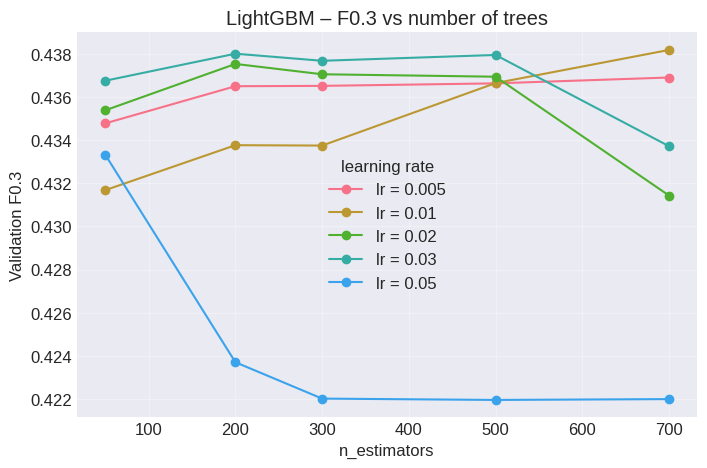

In [11]:
import itertools, random, pandas as pd, matplotlib.pyplot as plt
from lightgbm import LGBMClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

def lightgbm_grid_search(
        X_train, y_train, X_val, y_val,
        features,               
        n_trials,                
        param_space
    ):

    keys, values = zip(*param_space.items())
    grid = [dict(zip(keys, v)) for v in itertools.product(*values)]
    random.Random(random_state).shuffle(grid)    # reproducible shuffle

    if n_trials < len(grid):
        grid = grid[:n_trials]         

    print(f"Grid search – {len(grid)} combos (budget = {n_trials})")
    print("=" * 60)

    best_score, best_params, records = 0, {}, []

    for idx, params in enumerate(grid, 1):
        params["random_state"] = random_state
        print(f"[{idx:02d}/{len(grid):02d}] "
              f"lr={params['learning_rate']:.3f}  "
              f"estim={params['n_estimators']:3d}")

        preproc = ColumnTransformer(
            [("num",  "passthrough", features),
             ("date", DateFeatureTransformer(), ["created_at"])],
            remainder="drop"
        )

        pipe = Pipeline([
            ("preprocessor", preproc),
            ("model", LGBMClassifier(**params, n_jobs=-1))
        ])

        pipe, f03_tr, f03_val, threshold = fit_and_evaluate_pipeline(
            pipe, X_train, y_train, X_val, y_val)

        records.append({"learning_rate": params["learning_rate"],
                        "n_estimators" : params["n_estimators"],
                        "F0.3_train"   : f03_tr,
                        "F0.3_val"     : f03_val,
                        "Threshold"   : threshold})

        if f03_val > best_score:
            best_score, best_params = f03_val, params.copy()

    print("\n" + "="*60)
    print(f"BEST CONFIG – Val F0.3 = {best_score:.4f}")
    for k, v in best_params.items():
        if k != "random_state":
            print(f"  {k}: {v}")

    best_pipe = Pipeline([
        ("preprocessor", preproc),
        ("model", LGBMClassifier(**best_params, n_jobs=-1))
    ])
    best_pipe, f03_tr_best, f03_val_best, threshold = fit_and_evaluate_pipeline(
        best_pipe, X_train, y_train, X_val, y_val)

    print(f"\nSanity check → Train F0.3: {f03_tr_best:.4f} | "
          f"Val F0.3: {f03_val_best:.4f} | Threshold: {threshold:.3f}")

    df = (pd.DataFrame(records)
            .sort_values("n_estimators"))  

    fig, ax = plt.subplots(figsize=(8, 5))
    for lr, grp in df.groupby("learning_rate"):
        ax.plot(grp["n_estimators"], grp["F0.3_val"],
                marker="o", linestyle="-", label=f"lr = {lr}")
    ax.set_xlabel("n_estimators")
    ax.set_ylabel("Validation F0.3")
    ax.set_title("LightGBM – F0.3 vs number of trees")
    ax.grid(alpha=0.3)
    ax.legend(title="learning rate")
    plt.show()

    return df, best_pipe


param_space = {
    "num_leaves"        : [31],                
    "max_depth"         : [-1],                
    "learning_rate"     : [0.005, 0.01, 0.02, 0.03, 0.05],
    "n_estimators"      : [50, 200, 300, 500, 700],
    "min_child_samples" : [20],
    "subsample"         : [0.7],
    "colsample_bytree"  : [0.7],
}

df_res, best_model = lightgbm_grid_search(
        X_train, y_train, X_val, y_val,
        numeric_cols,   
        n_trials=100, 
        param_space=param_space)


We have found the best model with a ``F0.3 Score (Validation): 0.4382``. Seems that learning rate 0.005 with more estimators continues improving

Lets explore learning rate 0.005 and higher number of estimators

Grid search – 6 combos (budget = 6)
[01/06] lr=0.010  estim=1000
[LightGBM] [Info] Number of positive: 23687, number of negative: 1904275
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.039752 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1483
[LightGBM] [Info] Number of data points in the train set: 1927962, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.012286 -> initscore=-4.386930
[LightGBM] [Info] Start training from score -4.386930
   ⌛ fitted in 44.56s
   🎯 F0.3  (train)      : 0.4682
   🎯 F0.3  (validation) : 0.4372
   🔑 Best threshold     : 0.457
[02/06] lr=0.010  estim=300
[LightGBM] [Info] Number of positive: 23687, number of negative: 1904275
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.266853 seconds.
You can set `force_row_wise=true` to remove the 

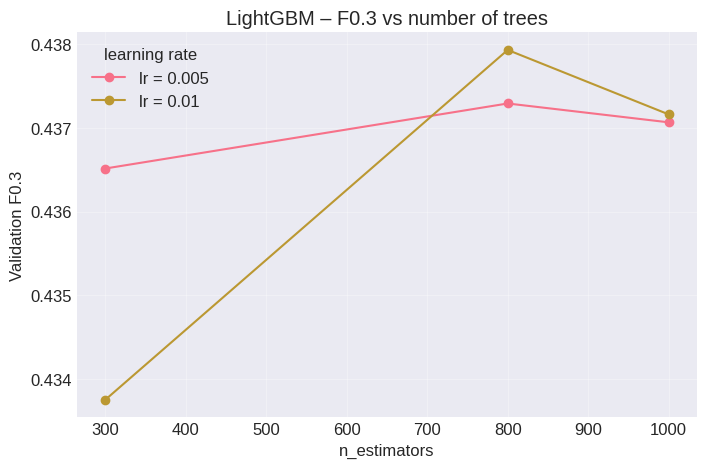

In [12]:
import itertools, random, pandas as pd, matplotlib.pyplot as plt
from lightgbm import LGBMClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

def lightgbm_grid_search(
        X_train, y_train, X_val, y_val,
        features,               
        n_trials,                
        param_space
    ):

    keys, values = zip(*param_space.items())
    grid = [dict(zip(keys, v)) for v in itertools.product(*values)]
    random.Random(random_state).shuffle(grid)    # reproducible shuffle

    if n_trials < len(grid):
        grid = grid[:n_trials]         

    print(f"Grid search – {len(grid)} combos (budget = {n_trials})")
    print("=" * 60)

    best_score, best_params, records = 0, {}, []

    for idx, params in enumerate(grid, 1):
        params["random_state"] = random_state
        print(f"[{idx:02d}/{len(grid):02d}] "
              f"lr={params['learning_rate']:.3f}  "
              f"estim={params['n_estimators']:3d}")

        preproc = ColumnTransformer(
            [("num",  "passthrough", features),
             ("date", DateFeatureTransformer(), ["created_at"])],
            remainder="drop"
        )

        pipe = Pipeline([
            ("preprocessor", preproc),
            ("model", LGBMClassifier(**params, n_jobs=-1))
        ])

        pipe, f03_tr, f03_val, threshold = fit_and_evaluate_pipeline(
            pipe, X_train, y_train, X_val, y_val)

        records.append({"learning_rate": params["learning_rate"],
                        "n_estimators" : params["n_estimators"],
                        "F0.3_train"   : f03_tr,
                        "F0.3_val"     : f03_val,
                        "Threshold"   : threshold})

        if f03_val > best_score:
            best_score, best_params = f03_val, params.copy()

    print("\n" + "="*60)
    print(f"BEST CONFIG – Val F0.3 = {best_score:.4f}")
    for k, v in best_params.items():
        if k != "random_state":
            print(f"  {k}: {v}")

    best_pipe = Pipeline([
        ("preprocessor", preproc),
        ("model", LGBMClassifier(**best_params, n_jobs=-1))
    ])
    best_pipe, f03_tr_best, f03_val_best, threshold = fit_and_evaluate_pipeline(
        best_pipe, X_train, y_train, X_val, y_val)

    print(f"\nSanity check → Train F0.3: {f03_tr_best:.4f} | "
          f"Val F0.3: {f03_val_best:.4f} | Threshold: {threshold:.3f}")

    df = (pd.DataFrame(records)
            .sort_values("n_estimators"))  

    fig, ax = plt.subplots(figsize=(8, 5))
    for lr, grp in df.groupby("learning_rate"):
        ax.plot(grp["n_estimators"], grp["F0.3_val"],
                marker="o", linestyle="-", label=f"lr = {lr}")
    ax.set_xlabel("n_estimators")
    ax.set_ylabel("Validation F0.3")
    ax.set_title("LightGBM – F0.3 vs number of trees")
    ax.grid(alpha=0.3)
    ax.legend(title="learning rate")
    plt.show()

    return df, best_pipe


param_space = {
    "num_leaves"        : [31],                
    "max_depth"         : [-1],                
    "learning_rate"     : [0.005, 0.01, 0.02, 0.03, 0.05],
    "n_estimators"      : [50, 200, 300, 500, 700],
    "min_child_samples" : [20],
    "subsample"         : [0.7],
    "colsample_bytree"  : [0.7],
}

df_res, best_model = lightgbm_grid_search(
        X_train, y_train, X_val, y_val,
        numeric_cols,   
        n_trials=100, 
        param_space=param_space)


param_space = {
    "num_leaves"        : [31],
    "max_depth"         : [-1],
    "learning_rate"     : [0.005, 0.01],
    "n_estimators"      : [300, 800, 1000],
    "min_child_samples" : [20],
    "subsample"         : [0.7],
    "colsample_bytree"  : [0.7],
}

df_res, best_model = lightgbm_grid_search(
        X_train, y_train, X_val, y_val,
        numeric_cols,
        n_trials=6,
        param_space=param_space)

We haven't found a better model, lets see what happen if we add categorical columns

Grid search – 12 combos (budget = 100)
[01/12] lr=0.015  estim=800
[LightGBM] [Info] Number of positive: 23687, number of negative: 1904275
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.073529 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1648
[LightGBM] [Info] Number of data points in the train set: 1927962, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.012286 -> initscore=-4.386930
[LightGBM] [Info] Start training from score -4.386930
   ⌛ fitted in 44.17s
   🎯 F0.3  (train)      : 0.4677
   🎯 F0.3  (validation) : 0.4324
   🔑 Best threshold     : 0.489
[02/12] lr=0.010  estim=1000
[LightGBM] [Info] Number of positive: 23687, number of negative: 1904275
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.292809 seconds.
You can set `force_row_wise=true` to remove t

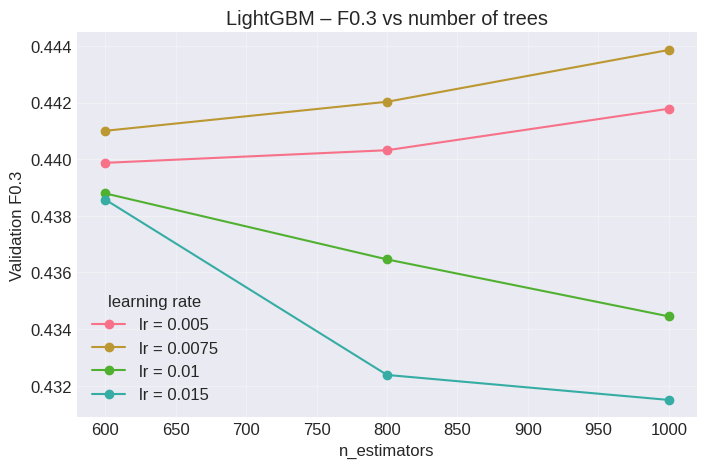

In [14]:
def lightgbm_cat_grid_search(
        X_train, y_train, X_val, y_val,
        numeric_cols, cat_cols, n_trials,                
        param_space
    ):

    keys, values = zip(*param_space.items())
    grid = [dict(zip(keys, v)) for v in itertools.product(*values)]
    random.Random(random_state).shuffle(grid)    # reproducible shuffle

    if n_trials < len(grid):
        grid = grid[:n_trials]         

    print(f"Grid search – {len(grid)} combos (budget = {n_trials})")
    print("=" * 60)

    best_score, best_params, records = 0, {}, []

    for idx, params in enumerate(grid, 1):
        params["random_state"] = random_state
        print(f"[{idx:02d}/{len(grid):02d}] "
              f"lr={params['learning_rate']:.3f}  "
              f"estim={params['n_estimators']:3d}")

        preproc = ColumnTransformer(
            [("num",  "passthrough", numeric_cols),
             ("cat", FrequencyEncoder(cat_cols), cat_cols),
             ("date", DateFeatureTransformer(), ["created_at"])],
            remainder="drop"
        )

        pipe = Pipeline([
            ("preprocessor", preproc),
            ("model", LGBMClassifier(**params, n_jobs=-1))
        ])

        pipe, f03_tr, f03_val, threshold = fit_and_evaluate_pipeline(
            pipe, X_train, y_train, X_val, y_val)

        records.append({"learning_rate": params["learning_rate"],
                        "n_estimators" : params["n_estimators"],
                        "F0.3_train"   : f03_tr,
                        "F0.3_val"     : f03_val,
                        "Threshold"   : threshold})

        if f03_val > best_score:
            best_score, best_params = f03_val, params.copy()

    print("\n" + "="*60)
    print(f"BEST CONFIG – Val F0.3 = {best_score:.4f}")
    for k, v in best_params.items():
        if k != "random_state":
            print(f"  {k}: {v}")

    best_pipe = Pipeline([
        ("preprocessor", preproc),
        ("model", LGBMClassifier(**best_params, n_jobs=-1))
    ])
    best_pipe, f03_tr_best, f03_val_best, threshold = fit_and_evaluate_pipeline(
        best_pipe, X_train, y_train, X_val, y_val)

    print(f"\nSanity check → Train F0.3: {f03_tr_best:.4f} | "
          f"Val F0.3: {f03_val_best:.4f} | Threshold: {threshold:.3f}")

    df = (pd.DataFrame(records)
            .sort_values("n_estimators"))  

    fig, ax = plt.subplots(figsize=(8, 5))
    for lr, grp in df.groupby("learning_rate"):
        ax.plot(grp["n_estimators"], grp["F0.3_val"],
                marker="o", linestyle="-", label=f"lr = {lr}")
    ax.set_xlabel("n_estimators")
    ax.set_ylabel("Validation F0.3")
    ax.set_title("LightGBM – F0.3 vs number of trees")
    ax.grid(alpha=0.3)
    ax.legend(title="learning rate")
    plt.show()

    return df, best_pipe


param_space = {
    "num_leaves"        : [31],                
    "max_depth"         : [-1],                
    "learning_rate"     : [0.005, 0.0075, 0.01, 0.015],
    "n_estimators"      : [600, 800, 1000],
    "min_child_samples" : [20],
    "subsample"         : [0.7],
    "colsample_bytree"  : [0.7],
}

df_res, best_model = lightgbm_cat_grid_search(
        X_train, y_train, X_val, y_val,
        numeric_cols, categorical_cols,  
        n_trials=100, 
        param_space=param_space)


Lets see what happens with more estimators

Grid search – 9 combos (budget = 100)
[01/09] lr=0.008  estim=800
[LightGBM] [Info] Number of positive: 23687, number of negative: 1904275
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.156805 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1648
[LightGBM] [Info] Number of data points in the train set: 1927962, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.012286 -> initscore=-4.386930
[LightGBM] [Info] Start training from score -4.386930
   ⌛ fitted in 56.57s
   🎯 F0.3  (train)      : 0.4606
   🎯 F0.3  (validation) : 0.4400
   🔑 Best threshold     : 0.433
[02/09] lr=0.008  estim=1200
[LightGBM] [Info] Number of positive: 23687, number of negative: 1904275
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.057411 seconds.
You can set `force_row_wise=true` to remove th

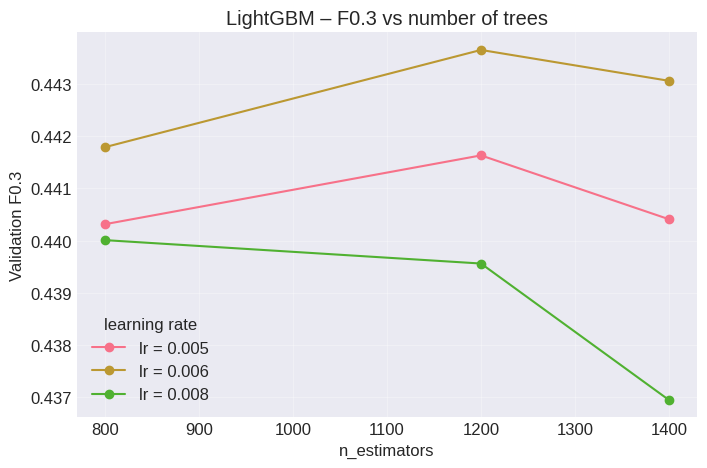

In [15]:
param_space = {
    "num_leaves"        : [31],                
    "max_depth"         : [-1],                
    "learning_rate"     : [0.005, 0.006, 0.008],
    "n_estimators"      : [800, 1200, 1400],
    "min_child_samples" : [20],
    "subsample"         : [0.7],
    "colsample_bytree"  : [0.7],
}

df_res, best_model = lightgbm_cat_grid_search(
        X_train, y_train, X_val, y_val,
        numeric_cols, categorical_cols,  
        n_trials=100, 
        param_space=param_space)


I havn't found a better model 

## Neural Network Baseline

Lets see how NN works with this dataset. Will be a quick exploration

In [16]:
from sklearn.neural_network import MLPClassifier

mlp_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("mlp", MLPClassifier(
        hidden_layer_sizes=(64, 32),     # two small dense layers
        activation="relu",
        solver="adam",
        alpha=1e-4,                      # L2 weight decay
        batch_size=256,                  # reasonable mini-batch for 2 M rows
        learning_rate_init=1e-3,
        max_iter=20,                     # keeps the test fast
        early_stopping=True,             # stops if val-loss stagnates
        n_iter_no_change=2,
        random_state=random_state,
        verbose=False
    ))
])

mlp_pipeline.fit(X_train[numeric_cols], y_train)

y_val_pred = mlp_pipeline.predict(X_val[numeric_cols])
f03_val = fbeta_03_score(y_val, y_val_pred)

print(f"MLP validation F0.3: {f03_val:.4f}")


MLP validation F0.3: 0.4142


# Best Model

In [12]:
from sklearn.ensemble import RandomForestClassifier

best_pipeline = Pipeline([
    ("preprocessor", ColumnTransformer(
        transformers=[
            ('num', 'passthrough', numeric_cols),
            ('cat', FrequencyEncoder(categorical_cols), categorical_cols),
            ('date', DateFeatureTransformer(), ['created_at'])
        ],
        remainder='drop'
    )),
    ("rf", RandomForestClassifier(
        n_estimators=120, 
        max_depth=8, 
        random_state=random_state, 
        n_jobs=-1
    ))
])
THRESHOLD = 0.252

time_start = time.time()
best_pipeline, f03_train, f03_test, threshold = fit_and_evaluate_pipeline(
    best_pipeline, X_train, y_train,
    X_test, y_test, THRESHOLD
)
print(f"Final model training time: {time.time() - time_start:.2f} seconds")
print(f"Final model F0.3 on test set: {f03_test:.4f} (threshold: {threshold:.3f})")


   ⌛ fitted in 54.34s
   🎯 F0.3  (train)      : 0.4710
   🎯 F0.3  (validation) : 0.4636
   🔑 Best threshold     : 0.252
Final model training time: 60.41 seconds
Final model F0.3 on test set: 0.4636 (threshold: 0.252)


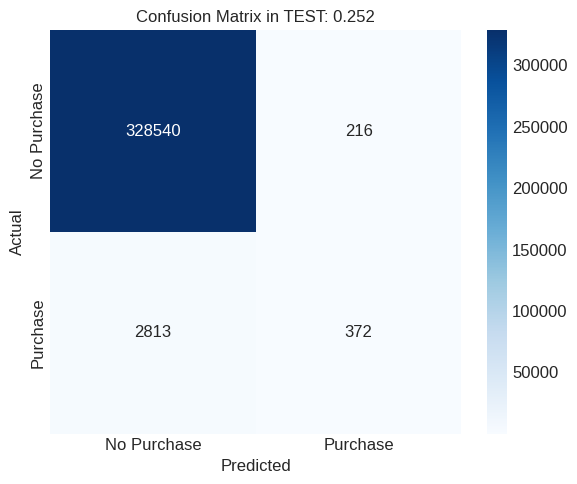

In [10]:
from sklearn.metrics import confusion_matrix

y_proba = best_pipeline.predict_proba(X_test)[:, 1]
y_pred = (y_proba >= THRESHOLD).astype(int)

# Plot confusión matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(
    cm, annot=True, fmt='d', cmap='Blues',
    xticklabels=['No Purchase', 'Purchase'],
    yticklabels=['No Purchase', 'Purchase']
)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title(f'Confusion Matrix in TEST: {THRESHOLD:.3f}', fontsize=12)
plt.tight_layout()
plt.show()